## Objectives

Introduce leak at node 6, node 2. The pressure measurement of these nodes will be used as a desired output for each of the optimization. Hence, the input function will be the considered emitter coefficient value of 0.5 and optimize for 100 generations. 

## Import Necessary Libraries

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import pygad
import numpy
import glob
import wntr
import os

In [2]:
plt.rcParams['figure.figsize'] = (12,8)

In [3]:
import warnings
import shutil
warnings.filterwarnings('ignore')

In [4]:
# wipe all solutions in the directory

try:
    shutil.rmtree('../leak_size_results/add_leak_node2/temp-new/')
    shutil.rmtree('../leak_size_results/add_leak_node2/plots-new/')
except FileNotFoundError as e:
    print(e)

# recreate deleted folders
os.makedirs('../leak_size_results/add_leak_node2/temp-new')
os.makedirs('../leak_size_results/add_leak_node2/plots-new')


# Uncomment and run the above code if you want to re-optimze this project otherwise, go ahead.
# Recommendation: Uncomment and run the code if you want re-optimize.

## Read Inp File

In [5]:
class Config:
    num_generations =100 #Number of generations.
    num_parents_mating = 2 # Number of solutions to be selected as parents in the mating pool.
    sol_per_pop = 30 # Number of solutions in the population.
    num_genes = 1 #len(function_inputs) --> this can be an array
    init_range_low = 0
    init_range_high = 1
    parent_selection_type = "sss" # Type of parent selection.
    keep_parents = -1 # Number of parents to keep in the next population. -1 means keep all parents and 0 means keep nothing.
    crossover_type = "single_point" # Type of the crossover operator. 
    mutation_type = "random" # Type of the mutation operator.
    last_fitness = 0
    mutation_percent_genes = 100
    
    
    inp_file_path = r"../data/Real_Synthetic_Net.inp" 
    function_inputs = None
    desired_output = None

In [6]:
class WaterLeakModel(Config):
    
    def __init__(self, node:str):
        ''' 
            node: node/junction ID in the network
        '''
        
        # Check if node is in network 
        wn = wntr.network.WaterNetworkModel(self.inp_file_path)
        assert wn.junction_name_list.count(node) == 1, "Node not found in the network"
        
        self.node = node
        
        #Setup all neccessary folders we need to work with, i.e. create them if they don't exist
        if not os.path.exists('../leak_size_results/add_leak_node2/temp-new/solutions_for_'+self.node):
            os.mkdir('../leak_size_results/add_leak_node2/temp-new/solutions_for_'+self.node)
            
        if not os.path.exists('../leak_size_results/add_leak_node2/plots-new/plots_for_'+self.node):
            os.mkdir('../leak_size_results/add_leak_node2/plots-new/plots_for_'+self.node)
        
        if not os.path.exists('../leak_size_results/add_leak_node2/merged_results-new/'):
            os.mkdir('../leak_size_results/add_leak_node2/merged_results-new/')
            
        self.temp_dir = '../leak_size_results/add_leak_node2/temp-new/solutions_for_'+self.node
        self.plots_dir = '../leak_size_results/add_leak_node2/plots-new/plots_for_'+self.node
        self.merged_results = '../leak_size_results/add_leak_node2/merged_results-new/results_for_'
        
    
    def simulate(self, wn, plot_graph=True):
        """
        If plot_graph is set to true, a graph of the network is plotted after simulation
        """
        # Plot pressure after add leak to node
            
        sim = wntr.sim.WNTRSimulator(wn)
        results = sim.run_sim()
        pressure = results.node['pressure']
        pressure_at_N6 = pressure.loc[:,self.node]
        
        if plot_graph:
            wntr.graphics.plot_network(wn, node_attribute=pressure.any(), node_size=150, title='pressure at 0 hours')
        
        return results
    
    def change_discharge_coefficient(self, wn, emitter_value):
        """
        This function changes the emitter coefficient for selected node in the network, and create a 
        structured representation of our data, a csv.
        
        parameters
        ----------
        wn: wntr network object
        emitter_value: the emitter coefficient value
        """
        
        if emitter_value > 1:
            emitter_value %=1
            
        # Change emitter coefficient
        node = wn.get_node(str(self.node))
        node.add_leak(wn, area=0.00015, start_time=0, end_time=1, discharge_coeff=emitter_value)
        return self.simulate(wn, plot_graph=False)
    
    def export_results(self, solutions:list,  name:str, path=None):
        """
        Concatenates all solutions generated and exports as a single csv file
        
        parameters
        ----------
        solution: a list of all paths to the solutions csv files
        path: path where concatenated solution will be exported to
        name: name to be assigned to exported file
        """
        if not path: path=self.merged_results
            
        if not os.path.exists(path):
            os.mkdir(path)
        
        temp = pd.DataFrame()
        for i in range(len(solutions)):
            data = pd.read_csv(solutions[i])
            if i == 0:
                temp = data
            else:
                temp = pd.concat([temp, data])
        name+=".csv"
        try:
            temp.to_csv(os.path.join(path,name),index=False)
            print(f'File Exported Successfully to path: {os.path.join(path, name)}')
        except Exception as e:
            print(e)
            
    def run(self, leak_area=0.00015, start_time=0, end_time=1, discharge_coeff=.5, function_inputs=.5, plot_graph=True):
        """
        Adds a leak to node passed to WaterLeakModel() object and simulates
        
        parameters
        ----------
        leak_area: area of the leak
        start_time: time in seconds to start the leak
        end_time: time in seconds to end the leak
        discharge_coeff: Leak discharge coefficient; Takes on values between 0 and 1.
        function_inputs = inputs for optimization, can be array of numbers
        plot_graph: If plot_graph is set to true, a graph of the network is plotted after simulation
        """
            
        # Add leak and simulate
        wn = wntr.network.WaterNetworkModel(self.inp_file_path)
        node = wn.get_node(self.node)
        node.add_leak(wn, area=0.00015, start_time=start_time, end_time=end_time, discharge_coeff=discharge_coeff)
        results = self.simulate(wn, plot_graph=plot_graph)

        self.function_inputs = function_inputs
        self.desired_output = node.head-node.elevation
        return results


# Experiment 2 

Validate our model by adding leak to a different node: `NODE 2`

In [7]:
# Add leak and optimize for another node outside node 6 and make plots.
water_model2 = WaterLeakModel(node='N2')
wn = wntr.network.WaterNetworkModel(water_model2.inp_file_path)
pressure_at_0hr = water_model2.simulate(wn, plot_graph=False)
pressure_at_0hr.node['pressure']

,N1,N5,N10,N7,N2,N6,N3,N8,N13,N9,N14,N4,N11,N12,N15,N16,Reservior
0,9.370611,24.023646,28.970101,27.256189,24.870362,26.61794,27.085028,25.159246,30.595309,24.372273,25.061021,29.000316,27.842038,24.588272,28.966055,27.253194,0.0


,N1,N5,N10,N7,N2,N6,N3,N8,N13,N9,N14,N4,N11,N12,N15,N16,Reservior
0,9.345063,23.992041,28.938496,27.208607,24.814418,26.572414,27.030679,25.109823,30.545885,24.321985,25.010733,28.945966,27.810434,24.538849,28.934451,27.205612,0.0


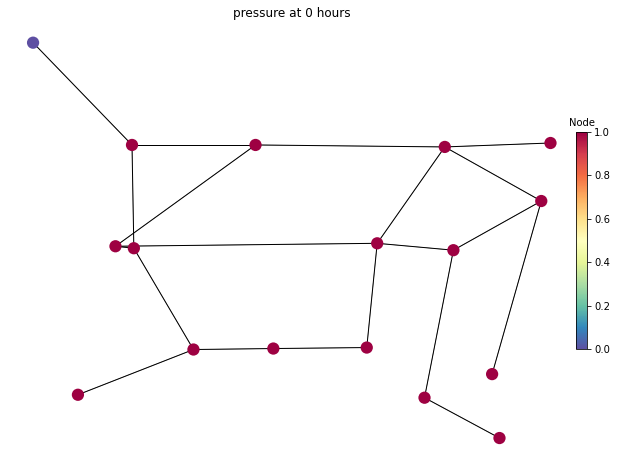

In [8]:
results = water_model2.run() # Add leak and simulate by calling the run method
results.node['pressure']

In [9]:
def fitness_function(solution, solution_idx):
        
    wn = wntr.network.WaterNetworkModel(water_model2.inp_file_path)
    results = water_model2.change_discharge_coefficient(wn, emitter_value=abs(solution[0]*water_model2.function_inputs)) #change emitter coefficient

    pressure = results.node['pressure']
    pressure_output = pressure.loc[:,water_model2.node]
    
    demands=results.node['demand']
    demand_output = demands.loc[:,water_model2.node]

    fitness = 1.0 / (np.abs(pressure_output - water_model2.desired_output) + 0.000001)

    # Structure and export the output of the fitness
    data = pd.DataFrame(columns=['EMITTER_COEFFICIENT_SOLUTION','PRESSURE_OUTPUT','OUTPUT_DEMAND','FITNESS'])
    data = data.append({'EMITTER_COEFFICIENT_SOLUTION':abs(solution[0]*water_model2.function_inputs),'PRESSURE_OUTPUT':list(pressure_output)[0],'FITNESS':list(fitness)[0],'OUTPUT_DEMAND':(list(demand_output) [0]*1000)},ignore_index=True)
    data.to_csv(f"{water_model2.temp_dir}/FITNESS_SOLUTION_{str(abs(solution[0]))}.csv",index=False) 

    print('=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========')
    print ('======|', abs(round(solution[0],3)),'|===========|',list(round(pressure_output,3))[0],'|==================|',list(round(fitness, 3))[0],'|==========')
    print('================================='*2)

    return list(fitness)[0]

In [10]:
#################### Create a Callback Function ########################
last_fitness = 0
def callback_generation(ga_instance): # This function prints algorithm progress
    global last_fitness
    print("Generation = {generation}".format(generation=ga_instance.generations_completed)) 
    print("Fitness = {fitness}".format(fitness=ga_instance.best_solution()[1]))
    print("Change = {change}".format(change=ga_instance.best_solution()[1] - last_fitness)) 

    data =pd.DataFrame(columns=['GENERATION','FITNESS'])
    data =data.append({'GENERATION':ga_instance.generations_completed,'FITNESS': ga_instance.best_solution ()[1]},ignore_index=True)
    data.to_csv(f"{water_model2.temp_dir}/GENERATION_{str(ga_instance.generations_completed)}.csv",index=False) 
    last_fitness = ga_instance.best_solution()[1]

In [11]:
# Instantiate the pygad optimization class
ga_instance2 = pygad.GA(num_generations=water_model2.num_generations,
                       num_parents_mating=water_model2.num_parents_mating, 
                       fitness_func=fitness_function, 
                       sol_per_pop=water_model2.sol_per_pop,
                       num_genes=water_model2.num_genes,
                       init_range_low=water_model2.init_range_low,
                       init_range_high=water_model2.init_range_high,
                       parent_selection_type=water_model2.parent_selection_type,
                       keep_parents=water_model2.keep_parents,
                       crossover_type=water_model2.crossover_type,
                       mutation_type=water_model2.mutation_type,
                       mutation_percent_genes=water_model2.mutation_percent_genes,
                       callback_generation=callback_generation)

In [12]:
ga_instance2.run()

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.966 |===========| 24.816 |==================| 514.061 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.384 |===========| 24.849 |==================| 28.898 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.383 |===========| 24.849 |==================| 28.85 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.259 |===========| 24.856 |==================| 24.074 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.729 |===========| 24.83 |==================| 65.436 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.519 |===========| 24.841 |==================| 36.978 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.483 |===========| 24.843 |===========

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.7 |===========| 24.831 |==================| 59.295 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.87 |===========| 24.822 |==================| 136.052 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.735 |===========| 24.829 |==================| 67.018 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.186 |===========| 24.804 |==================| 95.054 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.9 |===========| 24.763 |==================| 19.535 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.246 |===========| 24.857 |==================| 23.666 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.548 |===========| 24.84 |===============

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.848 |===========| 24.766 |==================| 20.742 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.746 |===========| 24.772 |==================| 23.573 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.555 |===========| 24.783 |==================| 31.739 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.372 |===========| 24.793 |==================| 47.409 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.43 |===========| 24.79 |==================| 41.036 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.258 |===========| 24.856 |==================| 24.035 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.217 |===========| 24.858 |============

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.203 |===========| 24.803 |==================| 87.228 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.121 |===========| 24.864 |==================| 20.32 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.07 |===========| 24.866 |==================| 19.211 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.457 |===========| 24.789 |==================| 38.592 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.71 |===========| 24.831 |==================| 61.328 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.7 |===========| 24.831 |==================| 59.295 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.87 |===========| 24.822 |================

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.548 |===========| 24.84 |==================| 39.38 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.953 |===========| 24.817 |==================| 380.69 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.896 |===========| 24.82 |==================| 170.416 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.736 |===========| 24.773 |==================| 23.917 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.421 |===========| 24.847 |==================| 30.749 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.848 |===========| 24.766 |==================| 20.742 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.746 |===========| 24.772 |============

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.348 |===========| 24.795 |==================| 50.784 |==========
Generation = 2
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.759 |===========| 24.828 |==================| 73.696 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.228 |===========| 24.802 |==================| 77.512 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.429 |===========| 24.846 |==================| 31.174 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.763 |===========| 24.828 |==================| 74.741 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.015 |===========| 24.87 |==================| 18.149 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.602 |===========| 24.8

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.128 |===========| 24.807 |==================| 138.667 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.546 |===========| 24.783 |==================| 32.311 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.873 |===========| 24.822 |==================| 139.235 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.693 |===========| 24.832 |==================| 57.887 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.233 |===========| 24.857 |==================| 23.244 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.421 |===========| 24.847 |==================| 30.776 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.295 |===========| 24.854 |========

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.671 |===========| 24.776 |==================| 26.25 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.542 |===========| 24.84 |==================| 38.832 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.347 |===========| 24.851 |==================| 27.304 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.511 |===========| 24.842 |==================| 36.367 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.919 |===========| 24.762 |==================| 19.126 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.04 |===========| 24.812 |==================| 446.579 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.348 |===========| 24.795 |============

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.517 |===========| 24.785 |==================| 34.075 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.417 |===========| 24.791 |==================| 42.36 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.877 |===========| 24.821 |==================| 144.399 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.078 |===========| 24.866 |==================| 19.366 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.925 |===========| 24.819 |==================| 234.909 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.518 |===========| 24.785 |==================| 34.07 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.44 |===========| 24.789 |===========

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.118 |===========| 24.864 |==================| 20.235 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.624 |===========| 24.836 |==================| 47.219 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.387 |===========| 24.792 |==================| 45.613 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.694 |===========| 24.832 |==================| 57.972 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.505 |===========| 24.842 |==================| 35.926 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.618 |===========| 24.836 |==================| 46.475 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.391 |===========| 24.849 |==========

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.366 |===========| 24.85 |==================| 28.115 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.827 |===========| 24.824 |==================| 102.286 |==========
Change = 0.0
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.106 |===========| 24.808 |==================| 166.516 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.587 |===========| 24.838 |==================| 43.101 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.674 |===========| 24.833 |==================| 54.547 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.872 |===========| 24.822 |==================| 138.556 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.517 |===========| 24.

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.44 |===========| 24.789 |==================| 40.114 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.112 |===========| 24.808 |==================| 157.617 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.211 |===========| 24.859 |==================| 22.619 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.607 |===========| 24.78 |==================| 29.026 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.274 |===========| 24.855 |==================| 24.56 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.118 |===========| 24.864 |==================| 20.235 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.624 |===========| 24.836 |============

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.251 |===========| 24.856 |==================| 23.8 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.454 |===========| 24.845 |==================| 32.597 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.025 |===========| 24.813 |==================| 706.04 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.858 |===========| 24.822 |==================| 124.934 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.004 |===========| 24.814 |==================| 4020.828 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.683 |===========| 24.776 |==================| 25.779 |==========
Generation = 4
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.316 |===========| 24

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.355 |===========| 24.794 |==================| 49.747 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.077 |===========| 24.866 |==================| 19.361 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.244 |===========| 24.857 |==================| 23.581 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.759 |===========| 24.828 |==================| 73.727 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.004 |===========| 24.814 |==================| 4786.243 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.417 |===========| 24.791 |==================| 42.272 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.155 |===========| 24.806 |========

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.794 |===========| 24.769 |==================| 22.152 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.836 |===========| 24.824 |==================| 107.99 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.77 |===========| 24.827 |==================| 77.065 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.569 |===========| 24.839 |==================| 41.281 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.251 |===========| 24.856 |==================| 23.8 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.454 |===========| 24.845 |==================| 32.597 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.025 |===========| 24.813 |=============

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.831 |===========| 24.824 |==================| 104.693 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.303 |===========| 24.797 |==================| 58.341 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.516 |===========| 24.785 |==================| 34.162 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.052 |===========| 24.868 |==================| 18.839 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.263 |===========| 24.856 |==================| 24.197 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.453 |===========| 24.845 |==================| 32.521 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.675 |===========| 24.833 |=========

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.774 |===========| 24.77 |==================| 22.725 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.368 |===========| 24.85 |==================| 28.181 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.819 |===========| 24.825 |==================| 98.208 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.249 |===========| 24.8 |==================| 70.973 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.362 |===========| 24.85 |==================| 27.913 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.191 |===========| 24.86 |==================| 22.06 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.679 |===========| 24.776 |=================

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.164 |===========| 24.805 |==================| 107.922 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.347 |===========| 24.795 |==================| 50.922 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.613 |===========| 24.836 |==================| 45.9 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.686 |===========| 24.775 |==================| 25.658 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.956 |===========| 24.817 |==================| 404.284 |==========
Change = 0.0
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.783 |===========| 24.827 |==================| 81.801 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.831 |===========| 24.82

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.675 |===========| 24.833 |==================| 54.734 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.853 |===========| 24.823 |==================| 120.943 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.678 |===========| 24.833 |==================| 55.192 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.075 |===========| 24.866 |==================| 19.311 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.313 |===========| 24.853 |==================| 25.952 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.774 |===========| 24.77 |==================| 22.725 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.368 |===========| 24.85 |===========

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.124 |===========| 24.807 |==================| 142.276 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.052 |===========| 24.811 |==================| 338.673 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.739 |===========| 24.772 |==================| 23.798 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.571 |===========| 24.782 |==================| 30.868 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.402 |===========| 24.848 |==================| 29.771 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.488 |===========| 24.787 |==================| 36.177 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.753 |===========| 24.772 |========

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.092 |===========| 24.865 |==================| 19.663 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.941 |===========| 24.761 |==================| 18.661 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.821 |===========| 24.825 |==================| 98.903 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.13 |===========| 24.863 |==================| 20.517 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.168 |===========| 24.861 |==================| 21.445 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.538 |===========| 24.84 |==================| 38.53 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.543 |===========| 24.84 |==============

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.571 |===========| 24.782 |==================| 30.866 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.578 |===========| 24.838 |==================| 42.119 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.841 |===========| 24.767 |==================| 20.896 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.655 |===========| 24.834 |==================| 51.461 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.598 |===========| 24.837 |==================| 44.177 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.124 |===========| 24.807 |==================| 142.276 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.052 |===========| 24.811 |=========

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.753 |===========| 24.772 |==================| 23.364 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.958 |===========| 24.817 |==================| 420.684 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.026 |===========| 24.869 |==================| 18.352 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.566 |===========| 24.782 |==================| 31.131 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.863 |===========| 24.822 |==================| 129.029 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.738 |===========| 24.829 |==================| 67.807 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.224 |===========| 24.858 |========

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.434 |===========| 24.79 |==================| 40.695 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.595 |===========| 24.837 |==================| 43.858 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.34 |===========| 24.795 |==================| 51.953 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.122 |===========| 24.864 |==================| 20.328 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.379 |===========| 24.849 |==================| 28.681 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.875 |===========| 24.821 |==================| 141.454 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.164 |===========| 24.861 |===========

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.076 |===========| 24.866 |==================| 19.337 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.717 |===========| 24.774 |==================| 24.533 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.003 |===========| 24.814 |==================| 6456.084 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.025 |===========| 24.813 |==================| 713.477 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.401 |===========| 24.792 |==================| 43.964 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.74 |===========| 24.829 |==================| 68.413 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.22 |===========| 24.802 |=========

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.738 |===========| 24.829 |==================| 67.807 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.224 |===========| 24.858 |==================| 22.983 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.816 |===========| 24.768 |==================| 21.557 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.084 |===========| 24.81 |==================| 209.44 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.958 |===========| 24.817 |==================| 424.296 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.561 |===========| 24.783 |==================| 31.407 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.434 |===========| 24.79 |===========

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.801 |===========| 24.769 |==================| 21.952 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.46 |===========| 24.788 |==================| 38.324 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.9 |===========| 24.82 |==================| 176.943 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.961 |===========| 24.817 |==================| 450.311 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.818 |===========| 24.768 |==================| 21.508 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.828 |===========| 24.824 |==================| 102.993 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.069 |===========| 24.867 |===========

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.299 |===========| 24.854 |==================| 25.434 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.074 |===========| 24.866 |==================| 19.288 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.051 |===========| 24.868 |==================| 18.825 |==========
Fitness = 6456.0835083046395
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.469 |===========| 24.844 |==================| 33.543 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.023 |===========| 24.813 |==================| 762.02 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.804 |===========| 24.825 |==================| 90.304 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.13 |===

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.739 |===========| 24.772 |==================| 23.801 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.795 |===========| 24.826 |==================| 86.743 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.034 |===========| 24.813 |==================| 527.569 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.416 |===========| 24.847 |==================| 30.482 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.771 |===========| 24.771 |==================| 22.82 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.665 |===========| 24.833 |==================| 52.963 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.801 |===========| 24.769 |==========

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.069 |===========| 24.867 |==================| 19.193 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.899 |===========| 24.763 |==================| 19.551 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.952 |===========| 24.817 |==================| 371.554 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.553 |===========| 24.84 |==================| 39.743 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.628 |===========| 24.835 |==================| 47.732 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.299 |===========| 24.854 |==================| 25.434 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.074 |===========| 24.866 |==========

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.989 |===========| 24.815 |==================| 1637.362 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.88 |===========| 24.821 |==================| 147.838 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.031 |===========| 24.813 |==================| 566.454 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.887 |===========| 24.821 |==================| 156.558 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.949 |===========| 24.817 |==================| 349.584 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.218 |===========| 24.802 |==================| 81.021 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.368 |===========| 24.85 |======

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.42 |===========| 24.847 |==================| 30.695 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.177 |===========| 24.861 |==================| 21.679 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.118 |===========| 24.864 |==================| 20.24 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.777 |===========| 24.827 |==================| 79.587 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.583 |===========| 24.838 |==================| 42.65 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.224 |===========| 24.802 |==================| 79.056 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.939 |===========| 24.818 |=============

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.429 |===========| 24.846 |==================| 31.177 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.328 |===========| 24.852 |==================| 26.525 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.963 |===========| 24.76 |==================| 18.247 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.008 |===========| 24.87 |==================| 18.016 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.197 |===========| 24.859 |==================| 22.232 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.33 |===========| 24.796 |==================| 53.504 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.989 |===========| 24.815 |=============

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.533 |===========| 24.784 |==================| 33.09 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.228 |===========| 24.858 |==================| 23.116 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.935 |===========| 24.761 |==================| 18.785 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.008 |===========| 24.814 |==================| 2096.59 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.667 |===========| 24.777 |==================| 26.417 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.354 |===========| 24.851 |==================| 27.594 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.115 |===========| 24.808 |==========

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.546 |===========| 24.84 |==================| 39.157 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.157 |===========| 24.806 |==================| 112.453 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.677 |===========| 24.833 |==================| 55.007 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.933 |===========| 24.761 |==================| 18.839 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.997 |===========| 24.758 |==================| 17.606 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.892 |===========| 24.764 |==================| 19.693 |==========
Fitness = 6456.0835083046395
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.478 |==

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.062 |===========| 24.811 |==================| 284.516 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.685 |===========| 24.832 |==================| 56.36 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.406 |===========| 24.791 |==================| 43.457 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.964 |===========| 24.816 |==================| 486.344 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.533 |===========| 24.784 |==================| 33.09 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.228 |===========| 24.858 |==================| 23.116 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.935 |===========| 24.761 |==========

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.348 |===========| 24.851 |==================| 27.309 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.596 |===========| 24.837 |==================| 43.989 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.287 |===========| 24.854 |==================| 25.004 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.469 |===========| 24.788 |==================| 37.636 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.313 |===========| 24.853 |==================| 25.936 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.546 |===========| 24.84 |==================| 39.157 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.157 |===========| 24.806 |===========

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.053 |===========| 24.867 |==================| 18.869 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.638 |===========| 24.778 |==================| 27.621 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.704 |===========| 24.831 |==================| 60.017 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.716 |===========| 24.83 |==================| 62.538 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.789 |===========| 24.826 |==================| 84.074 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.061 |===========| 24.811 |==================| 289.406 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.702 |===========| 24.775 |==========

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.639 |===========| 24.835 |==================| 49.249 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.487 |===========| 24.843 |==================| 34.661 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.108 |===========| 24.864 |==================| 20.03 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.585 |===========| 24.781 |==================| 30.115 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.326 |===========| 24.852 |==================| 26.436 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.717 |===========| 24.83 |==================| 62.758 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.845 |===========| 24.766 |============

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.36 |===========| 24.85 |==================| 27.845 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.291 |===========| 24.854 |==================| 25.142 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.029 |===========| 24.813 |==================| 619.119 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.353 |===========| 24.794 |==================| 49.98 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.164 |===========| 24.861 |==================| 21.351 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.436 |===========| 24.79 |==================| 40.496 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.053 |===========| 24.867 |=============

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.435 |===========| 24.79 |==================| 40.532 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.616 |===========| 24.779 |==================| 28.611 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.425 |===========| 24.79 |==================| 41.533 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.574 |===========| 24.782 |==================| 30.706 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.935 |===========| 24.818 |==================| 273.292 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.047 |===========| 24.812 |==================| 374.162 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.642 |===========| 24.778 |==========

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.903 |===========| 24.763 |==================| 19.45 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.058 |===========| 24.867 |==================| 18.959 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.292 |===========| 24.854 |==================| 25.164 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.703 |===========| 24.774 |==================| 25.034 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.775 |===========| 24.77 |==================| 22.702 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.416 |===========| 24.791 |==================| 42.396 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.806 |===========| 24.825 |============

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.9 |===========| 24.82 |==================| 177.358 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.345 |===========| 24.795 |==================| 51.259 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.041 |===========| 24.812 |==================| 430.397 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.35 |===========| 24.795 |==================| 50.489 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.123 |===========| 24.807 |==================| 144.225 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.879 |===========| 24.821 |==================| 146.112 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.435 |===========| 24.79 |===========

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.047 |===========| 24.812 |==================| 374.162 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.642 |===========| 24.778 |==================| 27.454 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.164 |===========| 24.861 |==================| 21.357 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.998 |===========| 24.815 |==================| 9058.575 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.294 |===========| 24.798 |==================| 60.016 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.529 |===========| 24.841 |==================| 37.733 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.903 |===========| 24.763 |=======

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.747 |===========| 24.772 |==================| 23.543 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.564 |===========| 24.782 |==================| 31.232 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.731 |===========| 24.83 |==================| 65.941 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.371 |===========| 24.85 |==================| 28.319 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.728 |===========| 24.83 |==================| 65.381 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.725 |===========| 24.773 |==================| 24.26 |==========
Generation = 13
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.415 |===========| 24.847

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.934 |===========| 24.818 |==================| 268.287 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.778 |===========| 24.827 |==================| 79.841 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.182 |===========| 24.804 |==================| 97.333 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.463 |===========| 24.788 |==================| 38.066 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.712 |===========| 24.774 |==================| 24.728 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.115 |===========| 24.808 |==================| 153.949 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.029 |===========| 24.869 |========

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.574 |===========| 24.782 |==================| 30.713 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.52 |===========| 24.785 |==================| 33.903 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.816 |===========| 24.768 |==================| 21.546 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.025 |===========| 24.813 |==================| 700.343 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.417 |===========| 24.791 |==================| 42.289 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.034 |===========| 24.813 |==================| 525.877 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.747 |===========| 24.772 |=========

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.725 |===========| 24.773 |==================| 24.26 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.846 |===========| 24.766 |==================| 20.783 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.561 |===========| 24.839 |==================| 40.476 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.565 |===========| 24.839 |==================| 40.869 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.1 |===========| 24.865 |==================| 19.838 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.862 |===========| 24.822 |==================| 128.363 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.769 |===========| 24.827 |============

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.638 |===========| 24.835 |==================| 49.151 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.038 |===========| 24.868 |==================| 18.571 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.141 |===========| 24.863 |==================| 20.78 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.315 |===========| 24.797 |==================| 56.064 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.06 |===========| 24.867 |==================| 19.004 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.508 |===========| 24.842 |==================| 36.138 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.344 |===========| 24.851 |============

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.832 |===========| 24.824 |==================| 105.827 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.762 |===========| 24.828 |==================| 74.443 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.061 |===========| 24.811 |==================| 290.584 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.454 |===========| 24.845 |==================| 32.598 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.086 |===========| 24.81 |==================| 205.87 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.08 |===========| 24.81 |==================| 220.29 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.512 |===========| 24.785 |===========

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.769 |===========| 24.827 |==================| 76.946 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.18 |===========| 24.804 |==================| 98.392 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.231 |===========| 24.858 |==================| 23.204 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.437 |===========| 24.846 |==================| 31.606 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.834 |===========| 24.824 |==================| 106.684 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.638 |===========| 24.835 |==================| 49.151 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.038 |===========| 24.868 |==========

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.299 |===========| 24.797 |==================| 59.069 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.908 |===========| 24.82 |==================| 192.077 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.887 |===========| 24.821 |==================| 157.058 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.036 |===========| 24.868 |==================| 18.545 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.203 |===========| 24.859 |==================| 22.372 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.659 |===========| 24.834 |==================| 52.171 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.177 |===========| 24.861 |=========

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.984 |===========| 24.758 |==================| 17.848 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.881 |===========| 24.821 |==================| 149.395 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.621 |===========| 24.779 |==================| 28.357 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.101 |===========| 24.865 |==================| 19.867 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.661 |===========| 24.834 |==================| 52.344 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.618 |===========| 24.836 |==================| 46.518 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.906 |===========| 24.82 |==========

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.142 |===========| 24.862 |==================| 20.815 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.381 |===========| 24.849 |==================| 28.774 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.725 |===========| 24.773 |==================| 24.264 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.376 |===========| 24.849 |==================| 28.535 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.081 |===========| 24.866 |==================| 19.438 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.299 |===========| 24.797 |==================| 59.069 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.908 |===========| 24.82 |===========

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.177 |===========| 24.861 |==================| 21.696 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.089 |===========| 24.809 |==================| 199.419 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.617 |===========| 24.779 |==================| 28.529 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.439 |===========| 24.79 |==================| 40.185 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.488 |===========| 24.787 |==================| 36.135 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.151 |===========| 24.862 |==================| 21.027 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.865 |===========| 24.765 |==========

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.194 |===========| 24.86 |==================| 22.132 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.808 |===========| 24.769 |==================| 21.78 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.446 |===========| 24.846 |==================| 32.157 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.019 |===========| 24.869 |==================| 18.224 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.852 |===========| 24.766 |==================| 20.637 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.289 |===========| 24.854 |==================| 25.074 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.686 |===========| 24.832 |============

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.059 |===========| 24.867 |==================| 18.991 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.284 |===========| 24.855 |==================| 24.907 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.68 |===========| 24.832 |==================| 55.445 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.808 |===========| 24.768 |==================| 21.772 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.218 |===========| 24.858 |==================| 22.802 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.686 |===========| 24.775 |==================| 25.652 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.61 |===========| 24.78 |=============

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.925 |===========| 24.762 |==================| 18.985 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.865 |===========| 24.765 |==================| 20.332 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.925 |===========| 24.819 |==================| 235.706 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.932 |===========| 24.761 |==================| 18.853 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.845 |===========| 24.766 |==================| 20.816 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.772 |===========| 24.827 |==================| 77.747 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.194 |===========| 24.86 |==========

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.053 |===========| 24.867 |==================| 18.868 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.921 |===========| 24.762 |==================| 19.086 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.129 |===========| 24.807 |==================| 137.644 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.414 |===========| 24.791 |==================| 42.594 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.568 |===========| 24.782 |==================| 31.004 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.588 |===========| 24.838 |==================| 43.124 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.118 |===========| 24.808 |=========

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.577 |===========| 24.782 |==================| 30.544 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.951 |===========| 24.817 |==================| 364.455 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.297 |===========| 24.798 |==================| 59.488 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.381 |===========| 24.849 |==================| 28.783 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.273 |===========| 24.799 |==================| 64.715 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.179 |===========| 24.86 |==================| 21.734 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.977 |===========| 24.816 |==========

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.176 |===========| 24.861 |==================| 21.669 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.296 |===========| 24.798 |==================| 59.716 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.31 |===========| 24.853 |==================| 25.828 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.64 |===========| 24.835 |==================| 49.387 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.085 |===========| 24.866 |==================| 19.522 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.557 |===========| 24.839 |==================| 40.118 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.053 |===========| 24.867 |============

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.588 |===========| 24.838 |==================| 43.124 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.118 |===========| 24.808 |==================| 150.032 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.285 |===========| 24.798 |==================| 62.058 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.775 |===========| 24.77 |==================| 22.713 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.16 |===========| 24.805 |==================| 110.705 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.769 |===========| 24.827 |==================| 77.003 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.577 |===========| 24.782 |==========

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.732 |===========| 24.773 |==================| 24.034 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.127 |===========| 24.807 |==================| 139.045 |==========
Generation = 18
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.66 |===========| 24.834 |==================| 52.301 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.713 |===========| 24.831 |==================| 61.833 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.836 |===========| 24.767 |==================| 21.022 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.308 |===========| 24.797 |==================| 57.383 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.932 |===========| 24

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.514 |===========| 24.785 |==================| 34.329 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.487 |===========| 24.843 |==================| 34.663 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.55 |===========| 24.783 |==================| 32.041 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.668 |===========| 24.833 |==================| 53.448 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.349 |===========| 24.851 |==================| 27.352 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.568 |===========| 24.839 |==================| 41.2 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.981 |===========| 24.759 |=============

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.724 |===========| 24.773 |==================| 24.325 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.767 |===========| 24.771 |==================| 22.924 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.532 |===========| 24.784 |==================| 33.149 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.415 |===========| 24.847 |==================| 30.439 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.073 |===========| 24.866 |==================| 19.279 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.966 |===========| 24.759 |==================| 18.182 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.732 |===========| 24.773 |==========

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.098 |===========| 24.865 |==================| 19.805 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.593 |===========| 24.837 |==================| 43.707 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.104 |===========| 24.809 |==================| 169.796 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.061 |===========| 24.867 |==================| 19.033 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.521 |===========| 24.841 |==================| 37.177 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.895 |===========| 24.82 |==================| 168.387 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.188 |===========| 24.86 |==========

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.105 |===========| 24.809 |==================| 169.092 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.905 |===========| 24.82 |==================| 186.327 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.916 |===========| 24.819 |==================| 211.263 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.602 |===========| 24.837 |==================| 44.659 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.227 |===========| 24.802 |==================| 77.84 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.084 |===========| 24.866 |==================| 19.5 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.581 |===========| 24.838 |===========

======| 1.635 |===========| 24.778 |==================| 27.754 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.743 |===========| 24.772 |==================| 23.695 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.789 |===========| 24.826 |==================| 84.226 |==========
Change = 0.0
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.667 |===========| 24.777 |==================| 26.411 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.71 |===========| 24.831 |==================| 61.274 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.433 |===========| 24.846 |==================| 31.391 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.098 |===========| 24.865 |==================| 19.805 |==========
=====|SOLUTION|===========|OUTP

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.895 |===========| 24.82 |==================| 168.387 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.188 |===========| 24.86 |==================| 21.967 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.696 |===========| 24.775 |==================| 25.303 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.38 |===========| 24.793 |==================| 46.494 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.218 |===========| 24.802 |==================| 81.195 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.495 |===========| 24.843 |==================| 35.259 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.105 |===========| 24.809 |============

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.798 |===========| 24.769 |==================| 22.051 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.819 |===========| 24.825 |==================| 97.812 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.048 |===========| 24.812 |==================| 366.57 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.178 |===========| 24.804 |==================| 99.439 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.512 |===========| 24.842 |==================| 36.453 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.654 |===========| 24.777 |==================| 26.944 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.937 |===========| 24.818 |==========

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.234 |===========| 24.801 |==================| 75.509 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.405 |===========| 24.791 |==================| 43.613 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.061 |===========| 24.867 |==================| 19.02 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.923 |===========| 24.819 |==================| 229.793 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.491 |===========| 24.787 |==================| 35.905 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.543 |===========| 24.84 |==================| 38.96 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.792 |===========| 24.826 |============

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.407 |===========| 24.848 |==================| 30.014 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.337 |===========| 24.795 |==================| 52.404 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.116 |===========| 24.808 |==================| 151.879 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.888 |===========| 24.821 |==================| 158.81 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.316 |===========| 24.797 |==================| 55.96 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.229 |===========| 24.801 |==================| 77.265 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.798 |===========| 24.769 |==========

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.654 |===========| 24.777 |==================| 26.944 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.937 |===========| 24.818 |==================| 283.084 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.571 |===========| 24.782 |==================| 30.842 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.433 |===========| 24.846 |==================| 31.419 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.87 |===========| 24.822 |==================| 136.512 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.157 |===========| 24.806 |==================| 112.338 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.585 |===========| 24.781 |========

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.832 |===========| 24.824 |==================| 105.84 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.137 |===========| 24.863 |==================| 20.695 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.699 |===========| 24.775 |==================| 25.187 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.095 |===========| 24.865 |==================| 19.736 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.545 |===========| 24.84 |==================| 39.063 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.777 |===========| 24.827 |==================| 79.668 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.889 |===========| 24.821 |===========

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.229 |===========| 24.801 |==================| 77.18 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.478 |===========| 24.787 |==================| 36.885 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.936 |===========| 24.818 |==================| 275.203 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.797 |===========| 24.769 |==================| 22.075 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.84 |===========| 24.767 |==================| 20.921 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.976 |===========| 24.816 |==================| 734.45 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.274 |===========| 24.855 |===========

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.157 |===========| 24.806 |==================| 112.338 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.585 |===========| 24.781 |==================| 30.103 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.061 |===========| 24.811 |==================| 291.478 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.16 |===========| 24.861 |==================| 21.25 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.31 |===========| 24.797 |==================| 56.996 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.877 |===========| 24.765 |==================| 20.043 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.832 |===========| 24.824 |===========

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.508 |===========| 24.786 |==================| 34.697 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.808 |===========| 24.768 |==================| 21.763 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.695 |===========| 24.775 |==================| 25.328 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.463 |===========| 24.845 |==================| 33.128 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.974 |===========| 24.816 |==================| 669.147 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.601 |===========| 24.78 |==================| 29.333 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.829 |===========| 24.824 |==========

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.298 |===========| 24.854 |==================| 25.386 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.483 |===========| 24.843 |==================| 34.441 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.234 |===========| 24.857 |==================| 23.296 |==========
Fitness = 9058.575338796842
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.521 |===========| 24.841 |==================| 37.174 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.542 |===========| 24.784 |==================| 32.504 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.622 |===========| 24.836 |==================| 47.079 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.685 |===

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.237 |===========| 24.857 |==================| 23.387 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.622 |===========| 24.836 |==================| 47.034 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.757 |===========| 24.771 |==================| 23.252 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.082 |===========| 24.81 |==================| 216.995 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.43 |===========| 24.846 |==================| 31.238 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.508 |===========| 24.786 |==================| 34.697 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.808 |===========| 24.768 |===========

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.127 |===========| 24.863 |==================| 20.454 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.511 |===========| 24.785 |==================| 34.479 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.058 |===========| 24.867 |==================| 18.967 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.623 |===========| 24.779 |==================| 28.255 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.494 |===========| 24.843 |==================| 35.169 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.298 |===========| 24.854 |==================| 25.386 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.483 |===========| 24.843 |==========

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.374 |===========| 24.85 |==================| 28.478 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.646 |===========| 24.778 |==================| 27.245 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.95 |===========| 24.76 |==================| 18.488 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.091 |===========| 24.809 |==================| 193.475 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.989 |===========| 24.815 |==================| 1633.241 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.871 |===========| 24.765 |==================| 20.178 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.681 |===========| 24.832 |==========

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.274 |===========| 24.855 |==================| 24.543 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.55 |===========| 24.84 |==================| 39.534 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.178 |===========| 24.86 |==================| 21.71 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.087 |===========| 24.866 |==================| 19.566 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.06 |===========| 24.811 |==================| 295.794 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.107 |===========| 24.808 |==================| 165.091 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.043 |===========| 24.812 |=============

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.922 |===========| 24.819 |==================| 228.217 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.232 |===========| 24.801 |==================| 76.085 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.41 |===========| 24.791 |==================| 43.03 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.719 |===========| 24.774 |==================| 24.475 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.671 |===========| 24.833 |==================| 54.011 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.33 |===========| 24.852 |==================| 26.59 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.374 |===========| 24.85 |==============

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.349 |===========| 24.851 |==================| 27.37 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.685 |===========| 24.776 |==================| 25.72 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.143 |===========| 24.862 |==================| 20.822 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.88 |===========| 24.764 |==================| 19.975 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.198 |===========| 24.859 |==================| 22.253 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.094 |===========| 24.865 |==================| 19.713 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.976 |===========| 24.816 |=============

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.006 |===========| 24.87 |==================| 17.987 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.809 |===========| 24.825 |==================| 92.714 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.417 |===========| 24.791 |==================| 42.333 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.589 |===========| 24.838 |==================| 43.236 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.908 |===========| 24.82 |==================| 193.179 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.534 |===========| 24.784 |==================| 33.033 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.849 |===========| 24.823 |===========

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.35 |===========| 24.795 |==================| 50.464 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.587 |===========| 24.781 |==================| 30.011 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.576 |===========| 24.838 |==================| 41.906 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.944 |===========| 24.761 |==================| 18.618 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.458 |===========| 24.845 |==================| 32.868 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.667 |===========| 24.777 |==================| 26.407 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.349 |===========| 24.851 |===========

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.976 |===========| 24.816 |==================| 746.225 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.833 |===========| 24.824 |==================| 106.04 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.352 |===========| 24.851 |==================| 27.489 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.535 |===========| 24.784 |==================| 32.975 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.439 |===========| 24.79 |==================| 40.194 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.006 |===========| 24.87 |==================| 17.987 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.809 |===========| 24.825 |===========

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.444 |===========| 24.789 |==================| 39.732 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.955 |===========| 24.817 |==================| 395.396 |==========
Generation = 25
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.481 |===========| 24.787 |==================| 36.64 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.014 |===========| 24.87 |==================| 18.131 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.2 |===========| 24.859 |==================| 22.293 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.266 |===========| 24.799 |==================| 66.443 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.202 |===========| 24.85

======| 0.018 |===========| 24.869 |==================| 18.2 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.585 |===========| 24.838 |==================| 42.875 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.428 |===========| 24.79 |==================| 41.263 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.691 |===========| 24.775 |==================| 25.496 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.78 |===========| 24.77 |==================| 22.554 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.764 |===========| 24.771 |==================| 23.032 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.157 |===========| 24.862 |==================| 21.169 |==========
=====|SOLUTION|===========|OUTPUT|==============

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.506 |===========| 24.842 |==================| 36.034 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.439 |===========| 24.846 |==================| 31.729 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.137 |===========| 24.807 |==================| 128.889 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.332 |===========| 24.852 |==================| 26.68 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.603 |===========| 24.837 |==================| 44.792 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.968 |===========| 24.816 |==================| 547.897 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.037 |===========| 24.812 |=========

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.776 |===========| 24.77 |==================| 22.683 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.002 |===========| 24.814 |==================| 11371.759 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.879 |===========| 24.821 |==================| 146.774 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.8 |===========| 24.826 |==================| 88.535 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.071 |===========| 24.866 |==================| 19.232 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.888 |===========| 24.821 |==================| 157.873 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.177 |===========| 24.804 |========

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.763 |===========| 24.771 |==================| 23.063 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.145 |===========| 24.862 |==================| 20.89 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.284 |===========| 24.798 |==================| 62.131 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.633 |===========| 24.779 |==================| 27.846 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.37 |===========| 24.793 |==================| 47.685 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.077 |===========| 24.866 |==================| 19.351 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.549 |===========| 24.783 |============

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.912 |===========| 24.763 |==================| 19.263 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.321 |===========| 24.796 |==================| 54.989 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.975 |===========| 24.816 |==================| 713.864 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.358 |===========| 24.85 |==================| 27.763 |==========
Change = 2313.184072363776
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.531 |===========| 24.841 |==================| 37.967 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.48 |===========| 24.844 |==================| 34.228 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.776 |=====

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.888 |===========| 24.821 |==================| 157.873 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.177 |===========| 24.804 |==================| 99.872 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.384 |===========| 24.849 |==================| 28.903 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.031 |===========| 24.869 |==================| 18.439 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.238 |===========| 24.857 |==================| 23.405 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.177 |===========| 24.861 |==================| 21.69 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.763 |===========| 24.771 |==========

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.486 |===========| 24.843 |==================| 34.635 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.227 |===========| 24.858 |==================| 23.086 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.035 |===========| 24.868 |==================| 18.525 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.462 |===========| 24.845 |==================| 33.069 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.472 |===========| 24.788 |==================| 37.379 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.21 |===========| 24.859 |==================| 22.577 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.156 |===========| 24.806 |===========

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.265 |===========| 24.856 |==================| 24.276 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.236 |===========| 24.801 |==================| 75.024 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.025 |===========| 24.869 |==================| 18.326 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.234 |===========| 24.857 |==================| 23.285 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.918 |===========| 24.819 |==================| 215.059 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.493 |===========| 24.843 |==================| 35.076 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.423 |===========| 24.79 |==========

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.38 |===========| 24.849 |==================| 28.747 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.856 |===========| 24.766 |==================| 20.531 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.592 |===========| 24.781 |==================| 29.765 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.733 |===========| 24.773 |==================| 24.025 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.695 |===========| 24.832 |==================| 58.161 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.892 |===========| 24.764 |==================| 19.7 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.486 |===========| 24.843 |=============

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.21 |===========| 24.859 |==================| 22.577 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.156 |===========| 24.806 |==================| 113.226 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.955 |===========| 24.76 |==================| 18.385 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.168 |===========| 24.805 |==================| 105.479 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.052 |===========| 24.811 |==================| 338.525 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.106 |===========| 24.808 |==================| 167.525 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.927 |===========| 24.819 |========

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.093 |===========| 24.809 |==================| 190.477 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.117 |===========| 24.808 |==================| 151.278 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.279 |===========| 24.799 |==================| 63.294 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.321 |===========| 24.796 |==================| 55.072 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.75 |===========| 24.772 |==================| 23.456 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.463 |===========| 24.788 |==================| 38.098 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.778 |===========| 24.827 |=========

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.393 |===========| 24.848 |==================| 29.357 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.785 |===========| 24.827 |==================| 82.597 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.11 |===========| 24.808 |==================| 160.497 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.687 |===========| 24.775 |==================| 25.629 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.349 |===========| 24.795 |==================| 50.553 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.321 |===========| 24.796 |==================| 54.944 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.548 |===========| 24.783 |==========

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.106 |===========| 24.808 |==================| 167.525 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.927 |===========| 24.819 |==================| 242.837 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.113 |===========| 24.864 |==================| 20.136 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.067 |===========| 24.811 |==================| 263.78 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.143 |===========| 24.862 |==================| 20.826 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.046 |===========| 24.812 |==================| 381.459 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.093 |===========| 24.809 |=======

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.881 |===========| 24.764 |==================| 19.945 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.206 |===========| 24.803 |==================| 85.789 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.232 |===========| 24.801 |==================| 76.354 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.198 |===========| 24.803 |==================| 89.521 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.049 |===========| 24.868 |==================| 18.78 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.102 |===========| 24.865 |==================| 19.886 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.195 |===========| 24.86 |============

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.816 |===========| 24.825 |==================| 96.622 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.845 |===========| 24.766 |==================| 20.814 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.314 |===========| 24.797 |==================| 56.327 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.188 |===========| 24.86 |==================| 21.981 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.059 |===========| 24.867 |==================| 18.977 |==========
Fitness = 11371.759411160618
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.158 |===========| 24.805 |==================| 111.636 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.355 |==

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.849 |===========| 24.823 |==================| 117.253 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.338 |===========| 24.852 |==================| 26.921 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.008 |===========| 24.814 |==================| 2134.704 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.006 |===========| 24.87 |==================| 17.988 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.156 |===========| 24.806 |==================| 113.023 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.881 |===========| 24.764 |==================| 19.945 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.206 |===========| 24.803 |=======

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.195 |===========| 24.86 |==================| 22.16 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.415 |===========| 24.791 |==================| 42.553 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.904 |===========| 24.763 |==================| 19.442 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.687 |===========| 24.775 |==================| 25.612 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.158 |===========| 24.862 |==================| 21.193 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.569 |===========| 24.839 |==================| 41.249 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.816 |===========| 24.825 |============

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.67 |===========| 24.776 |==================| 26.28 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.142 |===========| 24.862 |==================| 20.807 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.932 |===========| 24.818 |==================| 260.126 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.865 |===========| 24.765 |==================| 20.311 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.485 |===========| 24.843 |==================| 34.571 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.851 |===========| 24.823 |==================| 119.079 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.161 |===========| 24.805 |==========

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.568 |===========| 24.782 |==================| 31.038 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.005 |===========| 24.87 |==================| 17.966 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.349 |===========| 24.851 |==================| 27.36 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.835 |===========| 24.824 |==================| 107.632 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.381 |===========| 24.793 |==================| 46.309 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.878 |===========| 24.821 |==================| 145.052 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.789 |===========| 24.77 |===========

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.471 |===========| 24.788 |==================| 37.443 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.144 |===========| 24.862 |==================| 20.849 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.002 |===========| 24.87 |==================| 17.904 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.12 |===========| 24.864 |==================| 20.294 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.449 |===========| 24.845 |==================| 32.318 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.67 |===========| 24.776 |==================| 26.28 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.142 |===========| 24.862 |==============

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.83 |===========| 24.824 |==================| 104.317 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.081 |===========| 24.81 |==================| 217.238 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.972 |===========| 24.759 |==================| 18.067 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.493 |===========| 24.786 |==================| 35.767 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.129 |===========| 24.863 |==================| 20.498 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.13 |===========| 24.807 |==================| 136.47 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.245 |===========| 24.857 |===========

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.856 |===========| 24.823 |==================| 122.861 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.227 |===========| 24.802 |==================| 77.791 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.405 |===========| 24.791 |==================| 43.536 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.069 |===========| 24.867 |==================| 19.194 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.012 |===========| 24.814 |==================| 1491.339 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.092 |===========| 24.809 |==================| 192.499 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.746 |===========| 24.829 |======

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.56 |===========| 24.783 |==================| 31.492 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.458 |===========| 24.788 |==================| 38.557 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.861 |===========| 24.765 |==================| 20.416 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.67 |===========| 24.776 |==================| 26.274 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.062 |===========| 24.811 |==================| 287.126 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.597 |===========| 24.837 |==================| 44.118 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.83 |===========| 24.824 |============

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.245 |===========| 24.857 |==================| 23.635 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.533 |===========| 24.841 |==================| 38.08 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.277 |===========| 24.855 |==================| 24.656 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.692 |===========| 24.775 |==================| 25.452 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.992 |===========| 24.758 |==================| 17.694 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.856 |===========| 24.823 |==================| 122.861 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.227 |===========| 24.802 |==========

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.822 |===========| 24.824 |==================| 99.463 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.025 |===========| 24.869 |==================| 18.329 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.273 |===========| 24.799 |==================| 64.739 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.319 |===========| 24.796 |==================| 55.39 |==========
Generation = 32
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.608 |===========| 24.78 |==================| 28.956 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.524 |===========| 24.841 |==================| 37.386 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.113 |===========| 24.8

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.524 |===========| 24.841 |==================| 37.361 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.915 |===========| 24.819 |==================| 207.985 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.8 |===========| 24.769 |==================| 21.995 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.801 |===========| 24.769 |==================| 21.945 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.194 |===========| 24.803 |==================| 91.033 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.595 |===========| 24.837 |==================| 43.866 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.392 |===========| 24.792 |===========

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.489 |===========| 24.843 |==================| 34.805 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.741 |===========| 24.772 |==================| 23.764 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.007 |===========| 24.87 |==================| 17.991 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.688 |===========| 24.775 |==================| 25.577 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.018 |===========| 24.869 |==================| 18.195 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.094 |===========| 24.809 |==================| 187.365 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.822 |===========| 24.824 |==========

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.379 |===========| 24.849 |==================| 28.668 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.263 |===========| 24.8 |==================| 67.227 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.677 |===========| 24.833 |==================| 55.067 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.496 |===========| 24.843 |==================| 35.321 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.704 |===========| 24.831 |==================| 60.041 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.515 |===========| 24.785 |==================| 34.256 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.977 |===========| 24.759 |============

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.707 |===========| 24.831 |==================| 60.535 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.921 |===========| 24.819 |==================| 224.911 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.085 |===========| 24.81 |==================| 207.79 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.842 |===========| 24.823 |==================| 112.351 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.726 |===========| 24.773 |==================| 24.256 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.177 |===========| 24.804 |==================| 99.704 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.529 |===========| 24.841 |=========

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.156 |===========| 24.806 |==================| 113.553 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.478 |===========| 24.844 |==================| 34.103 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.509 |===========| 24.842 |==================| 36.201 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.941 |===========| 24.818 |==================| 298.411 |==========
Change = 0.0
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.492 |===========| 24.787 |==================| 35.861 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.379 |===========| 24.849 |==================| 28.668 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.263 |===========| 24.

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.233 |===========| 24.801 |==================| 75.986 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.107 |===========| 24.808 |==================| 165.065 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.77 |===========| 24.771 |==================| 22.847 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.077 |===========| 24.81 |==================| 229.023 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.176 |===========| 24.804 |==================| 100.728 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.707 |===========| 24.831 |==================| 60.535 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.921 |===========| 24.819 |=========

======| 1.735 |===========| 24.773 |==================| 23.934 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.274 |===========| 24.855 |==================| 24.547 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.635 |===========| 24.835 |==================| 48.748 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.979 |===========| 24.759 |==================| 17.938 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.812 |===========| 24.768 |==================| 21.652 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.0 |===========| 24.814 |==================| 41506.09 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.081 |===========| 24.866 |==================| 19.432 |==========
=====|SOLUTION|===========|OUTPUT|=========

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.418 |===========| 24.791 |==================| 42.188 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.368 |===========| 24.85 |==================| 28.168 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.348 |===========| 24.851 |==================| 27.311 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.597 |===========| 24.781 |==================| 29.529 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.509 |===========| 24.786 |==================| 34.668 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.817 |===========| 24.825 |==================| 96.816 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.568 |===========| 24.839 |===========

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.243 |===========| 24.801 |==================| 72.84 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.208 |===========| 24.803 |==================| 84.855 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.782 |===========| 24.77 |==================| 22.506 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.642 |===========| 24.835 |==================| 49.703 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.735 |===========| 24.773 |==================| 23.934 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.274 |===========| 24.855 |==================| 24.547 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.635 |===========| 24.835 |============

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.15 |===========| 24.806 |==================| 117.628 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.338 |===========| 24.852 |==================| 26.905 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.616 |===========| 24.779 |==================| 28.609 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.783 |===========| 24.77 |==================| 22.47 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.871 |===========| 24.765 |==================| 20.178 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.675 |===========| 24.833 |==================| 54.599 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.331 |===========| 24.852 |============

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.885 |===========| 24.764 |==================| 19.869 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.18 |===========| 24.86 |==================| 21.765 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.711 |===========| 24.774 |==================| 24.774 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.727 |===========| 24.773 |==================| 24.218 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.778 |===========| 24.77 |==================| 22.626 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.866 |===========| 24.765 |==================| 20.306 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.973 |===========| 24.759 |=============

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.432 |===========| 24.79 |==================| 40.84 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.167 |===========| 24.805 |==================| 106.093 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.188 |===========| 24.86 |==================| 21.975 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.043 |===========| 24.868 |==================| 18.665 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.806 |===========| 24.825 |==================| 91.622 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.683 |===========| 24.832 |==================| 56.079 |==========
Change = 0.0
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.338 |===========| 24.852 

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.331 |===========| 24.852 |==================| 26.628 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.575 |===========| 24.782 |==================| 30.632 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.773 |===========| 24.827 |==================| 78.34 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.487 |===========| 24.787 |==================| 36.234 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.911 |===========| 24.819 |==================| 199.601 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.885 |===========| 24.764 |==================| 19.869 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.18 |===========| 24.86 |============

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.367 |===========| 24.794 |==================| 48.14 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.803 |===========| 24.769 |==================| 21.904 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.276 |===========| 24.855 |==================| 24.611 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.39 |===========| 24.792 |==================| 45.269 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.65 |===========| 24.777 |==================| 27.077 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.561 |===========| 24.783 |==================| 31.407 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.642 |===========| 24.778 |=============

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.515 |===========| 24.842 |==================| 36.65 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.424 |===========| 24.79 |==================| 41.642 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.637 |===========| 24.835 |==================| 48.959 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.155 |===========| 24.862 |==================| 21.115 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.923 |===========| 24.819 |==================| 229.923 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.526 |===========| 24.785 |==================| 33.508 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.402 |===========| 24.792 |===========

======| 0.749 |===========| 24.829 |==================| 70.773 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.925 |===========| 24.819 |==================| 237.757 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.087 |===========| 24.866 |==================| 19.562 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.534 |===========| 24.784 |==================| 33.004 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.536 |===========| 24.841 |==================| 38.336 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.396 |===========| 24.792 |==================| 44.538 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.367 |===========| 24.794 |==================| 48.14 |==========
=====|SOLUTION|===========|OUTPUT|=========

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.642 |===========| 24.778 |==================| 27.427 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.415 |===========| 24.847 |==================| 30.457 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.18 |===========| 24.86 |==================| 21.775 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.808 |===========| 24.769 |==================| 21.779 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.001 |===========| 24.87 |==================| 17.894 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.768 |===========| 24.771 |==================| 22.917 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.379 |===========| 24.849 |=============

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.693 |===========| 24.775 |==================| 25.407 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.96 |===========| 24.817 |==================| 446.94 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.85 |===========| 24.823 |==================| 118.631 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.038 |===========| 24.868 |==================| 18.573 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.827 |===========| 24.824 |==================| 102.645 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.788 |===========| 24.826 |==================| 83.606 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.676 |===========| 24.776 |==========

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.394 |===========| 24.848 |==================| 29.402 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.649 |===========| 24.834 |==================| 50.561 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.148 |===========| 24.806 |==================| 119.341 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.821 |===========| 24.768 |==================| 21.408 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.002 |===========| 24.87 |==================| 17.909 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.97 |===========| 24.816 |==================| 584.784 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.941 |===========| 24.761 |==========

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.107 |===========| 24.808 |==================| 165.8 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.682 |===========| 24.776 |==================| 25.83 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.27 |===========| 24.855 |==================| 24.415 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.209 |===========| 24.803 |==================| 84.57 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.584 |===========| 24.838 |==================| 42.773 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.693 |===========| 24.775 |==================| 25.407 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.96 |===========| 24.817 |===============

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.646 |===========| 24.834 |==================| 50.243 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.139 |===========| 24.863 |==================| 20.733 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.115 |===========| 24.864 |==================| 20.165 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.934 |===========| 24.761 |==================| 18.811 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.991 |===========| 24.815 |==================| 2034.022 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.206 |===========| 24.803 |==================| 85.695 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.869 |===========| 24.765 |========

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.91 |===========| 24.763 |==================| 19.311 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.119 |===========| 24.864 |==================| 20.267 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.335 |===========| 24.795 |==================| 52.674 |==========
Fitness = 41506.090188735936
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.967 |===========| 24.816 |==================| 535.177 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.408 |===========| 24.848 |==================| 30.065 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.271 |===========| 24.799 |==================| 65.311 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.338 |==

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.244 |===========| 24.801 |==================| 72.403 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.616 |===========| 24.836 |==================| 46.286 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.566 |===========| 24.839 |==================| 40.96 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.427 |===========| 24.847 |==================| 31.057 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.311 |===========| 24.797 |==================| 56.787 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.646 |===========| 24.834 |==================| 50.243 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.139 |===========| 24.863 |===========

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.319 |===========| 24.853 |==================| 26.188 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.645 |===========| 24.834 |==================| 50.08 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.593 |===========| 24.781 |==================| 29.694 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.429 |===========| 24.79 |==================| 41.103 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.565 |===========| 24.782 |==================| 31.216 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.91 |===========| 24.763 |==================| 19.311 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.119 |===========| 24.864 |=============

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.622 |===========| 24.779 |==================| 28.311 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.628 |===========| 24.779 |==================| 28.033 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.058 |===========| 24.811 |==================| 303.934 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.444 |===========| 24.846 |==================| 32.037 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.175 |===========| 24.861 |==================| 21.634 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.046 |===========| 24.812 |==================| 382.615 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.826 |===========| 24.767 |========

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.082 |===========| 24.81 |==================| 215.748 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.573 |===========| 24.838 |==================| 41.612 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.275 |===========| 24.855 |==================| 24.59 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.808 |===========| 24.768 |==================| 21.755 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.685 |===========| 24.832 |==================| 56.454 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.63 |===========| 24.779 |==================| 27.966 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.537 |===========| 24.784 |============

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.141 |===========| 24.863 |==================| 20.786 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.418 |===========| 24.791 |==================| 42.199 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.492 |===========| 24.787 |==================| 35.867 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.773 |===========| 24.77 |==================| 22.746 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.881 |===========| 24.764 |==================| 19.944 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.622 |===========| 24.779 |==================| 28.311 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.628 |===========| 24.779 |===========

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.593 |===========| 24.781 |==================| 29.704 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.882 |===========| 24.821 |==================| 150.462 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.44 |===========| 24.846 |==================| 31.807 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.44 |===========| 24.789 |==================| 40.126 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.799 |===========| 24.769 |==================| 22.006 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.123 |===========| 24.807 |==================| 144.177 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.926 |===========| 24.762 |==========

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.837 |===========| 24.824 |==================| 108.924 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.403 |===========| 24.792 |==================| 43.823 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.96 |===========| 24.76 |==================| 18.297 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.319 |===========| 24.796 |==================| 55.394 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.077 |===========| 24.866 |==================| 19.347 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.321 |===========| 24.796 |==================| 54.994 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.042 |===========| 24.868 |===========

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.777 |===========| 24.77 |==================| 22.637 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.905 |===========| 24.82 |==================| 186.352 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.318 |===========| 24.796 |==================| 55.56 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.351 |===========| 24.851 |==================| 27.445 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.596 |===========| 24.837 |==================| 43.983 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.4 |===========| 24.792 |==================| 44.081 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.593 |===========| 24.781 |==============

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.123 |===========| 24.807 |==================| 144.177 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.926 |===========| 24.762 |==================| 18.975 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.68 |===========| 24.832 |==================| 55.494 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.524 |===========| 24.785 |==================| 33.679 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.008 |===========| 24.87 |==================| 18.026 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.755 |===========| 24.772 |==================| 23.3 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.837 |===========| 24.824 |=============

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.044 |===========| 24.868 |==================| 18.688 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.76 |===========| 24.771 |==================| 23.151 |==========
Generation = 41
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.239 |===========| 24.857 |==================| 23.429 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.075 |===========| 24.81 |==================| 236.322 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.531 |===========| 24.841 |==================| 37.896 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.515 |===========| 24.785 |==================| 34.263 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.78 |===========| 24.8

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.427 |===========| 24.847 |==================| 31.07 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.612 |===========| 24.836 |==================| 45.842 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.778 |===========| 24.77 |==================| 22.603 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.31 |===========| 24.853 |==================| 25.815 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.855 |===========| 24.823 |==================| 122.54 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.284 |===========| 24.798 |==================| 62.154 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.039 |===========| 24.812 |=============

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.318 |===========| 24.853 |==================| 26.123 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.281 |===========| 24.855 |==================| 24.793 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.613 |===========| 24.78 |==================| 28.761 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.136 |===========| 24.807 |==================| 130.203 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.037 |===========| 24.812 |==================| 481.43 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.044 |===========| 24.868 |==================| 18.688 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.76 |===========| 24.771 |===========

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.814 |===========| 24.768 |==================| 21.615 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.389 |===========| 24.792 |==================| 45.435 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.213 |===========| 24.859 |==================| 22.667 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.556 |===========| 24.839 |==================| 40.029 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.145 |===========| 24.806 |==================| 122.386 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.08 |===========| 24.866 |==================| 19.409 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.189 |===========| 24.804 |==========

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.856 |===========| 24.823 |==================| 122.787 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.237 |===========| 24.801 |==================| 74.602 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.079 |===========| 24.81 |==================| 224.99 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.628 |===========| 24.835 |==================| 47.755 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.465 |===========| 24.788 |==================| 37.905 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.434 |===========| 24.846 |==================| 31.433 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.203 |===========| 24.803 |==========

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.444 |===========| 24.789 |==================| 39.758 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.395 |===========| 24.848 |==================| 29.448 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.465 |===========| 24.844 |==================| 33.257 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.681 |===========| 24.776 |==================| 25.837 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.634 |===========| 24.778 |==================| 27.779 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.814 |===========| 24.768 |==================| 21.615 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.389 |===========| 24.792 |==========

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.116 |===========| 24.864 |==================| 20.199 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.632 |===========| 24.779 |==================| 27.871 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.966 |===========| 24.816 |==================| 528.013 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.51 |===========| 24.785 |==================| 34.548 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.856 |===========| 24.823 |==================| 122.787 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.237 |===========| 24.801 |==================| 74.602 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.079 |===========| 24.81 |==========

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.484 |===========| 24.787 |==================| 36.453 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.956 |===========| 24.76 |==================| 18.371 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.975 |===========| 24.759 |==================| 18.014 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.228 |===========| 24.802 |==================| 77.631 |==========
Generation = 43
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.221 |===========| 24.858 |==================| 22.886 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.179 |===========| 24.804 |==================| 98.759 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.912 |===========| 24.

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.451 |===========| 24.845 |==================| 32.426 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.53 |===========| 24.841 |==================| 37.881 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.692 |===========| 24.832 |==================| 57.657 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.101 |===========| 24.809 |==================| 175.654 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.886 |===========| 24.764 |==================| 19.847 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.984 |===========| 24.758 |==================| 17.853 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.906 |===========| 24.763 |==========

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.611 |===========| 24.836 |==================| 45.701 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.321 |===========| 24.796 |==================| 55.042 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.257 |===========| 24.8 |==================| 68.759 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.715 |===========| 24.774 |==================| 24.622 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.674 |===========| 24.833 |==================| 54.489 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.484 |===========| 24.787 |==================| 36.453 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.956 |===========| 24.76 |=============

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.953 |===========| 24.817 |==================| 377.457 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.509 |===========| 24.786 |==================| 34.646 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.949 |===========| 24.76 |==================| 18.511 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.834 |===========| 24.824 |==================| 106.654 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.637 |===========| 24.778 |==================| 27.66 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.915 |===========| 24.819 |==================| 208.232 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.887 |===========| 24.764 |=========

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.108 |===========| 24.808 |==================| 163.32 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.67 |===========| 24.776 |==================| 26.297 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.788 |===========| 24.826 |==================| 83.826 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.211 |===========| 24.859 |==================| 22.621 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.957 |===========| 24.817 |==================| 416.678 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.861 |===========| 24.765 |==================| 20.424 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.658 |===========| 24.777 |==========

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.982 |===========| 24.815 |==================| 993.432 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.13 |===========| 24.807 |==================| 135.863 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.628 |===========| 24.779 |==================| 28.042 |==========
Change = 0.0
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.047 |===========| 24.812 |==================| 375.174 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.478 |===========| 24.844 |==================| 34.08 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.953 |===========| 24.817 |==================| 377.457 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.509 |===========| 24.

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.887 |===========| 24.764 |==================| 19.824 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.507 |===========| 24.786 |==================| 34.766 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.517 |===========| 24.785 |==================| 34.101 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.214 |===========| 24.802 |==================| 82.487 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.429 |===========| 24.79 |==================| 41.137 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.108 |===========| 24.808 |==================| 163.32 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.67 |===========| 24.776 |============

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.115 |===========| 24.864 |==================| 20.167 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.292 |===========| 24.854 |==================| 25.18 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.038 |===========| 24.868 |==================| 18.579 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.617 |===========| 24.779 |==================| 28.562 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.172 |===========| 24.805 |==================| 102.58 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.787 |===========| 24.77 |==================| 22.343 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.856 |===========| 24.823 |============

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.124 |===========| 24.807 |==================| 142.668 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.435 |===========| 24.846 |==================| 31.496 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.642 |===========| 24.835 |==================| 49.701 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.452 |===========| 24.789 |==================| 39.039 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.086 |===========| 24.866 |==================| 19.541 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.3 |===========| 24.854 |==================| 25.451 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.24 |===========| 24.857 |============

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.85 |===========| 24.766 |==================| 20.685 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.666 |===========| 24.777 |==================| 26.454 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.779 |===========| 24.77 |==================| 22.581 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.565 |===========| 24.782 |==================| 31.174 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.992 |===========| 24.815 |==================| 2180.28 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.283 |===========| 24.798 |==================| 62.509 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.115 |===========| 24.864 |===========

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.787 |===========| 24.77 |==================| 22.343 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.856 |===========| 24.823 |==================| 123.102 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.611 |===========| 24.78 |==================| 28.826 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.476 |===========| 24.844 |==================| 33.97 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.314 |===========| 24.853 |==================| 25.983 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.714 |===========| 24.831 |==================| 62.178 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.425 |===========| 24.79 |=============

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.577 |===========| 24.782 |==================| 30.545 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.359 |===========| 24.85 |==================| 27.782 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.339 |===========| 24.795 |==================| 52.157 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.733 |===========| 24.773 |==================| 23.998 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.438 |===========| 24.79 |==================| 40.317 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.381 |===========| 24.849 |==================| 28.766 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.633 |===========| 24.778 |============

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.527 |===========| 24.785 |==================| 33.47 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.898 |===========| 24.82 |==================| 173.001 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.829 |===========| 24.767 |==================| 21.199 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.408 |===========| 24.848 |==================| 30.076 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.435 |===========| 24.79 |==================| 40.588 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.06 |===========| 24.811 |==================| 293.2 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.145 |===========| 24.806 |==============

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.425 |===========| 24.79 |==================| 41.541 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.217 |===========| 24.858 |==================| 22.793 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.631 |===========| 24.835 |==================| 48.113 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.572 |===========| 24.838 |==================| 41.57 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.796 |===========| 24.826 |==================| 87.174 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.577 |===========| 24.782 |==================| 30.545 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.359 |===========| 24.85 |=============

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.57 |===========| 24.782 |==================| 30.947 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.281 |===========| 24.855 |==================| 24.784 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.824 |===========| 24.768 |==================| 21.348 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.952 |===========| 24.817 |==================| 372.558 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.301 |===========| 24.797 |==================| 58.674 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.059 |===========| 24.867 |==================| 18.976 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.609 |===========| 24.78 |===========

======| 1.732 |===========| 24.773 |==================| 24.033 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.31 |===========| 24.797 |==================| 56.921 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.859 |===========| 24.766 |==================| 20.453 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.876 |===========| 24.821 |==================| 142.916 |==========
Fitness = 41506.090188735936
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.111 |===========| 24.864 |==================| 20.089 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.315 |===========| 24.853 |==================| 26.022 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.159 |===========| 24.805 |==================| 110.896 |==========
=====|SOLUTIO

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.828 |===========| 24.824 |==================| 102.963 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.376 |===========| 24.849 |==================| 28.559 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.607 |===========| 24.837 |==================| 45.202 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.758 |===========| 24.771 |==================| 23.212 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.133 |===========| 24.807 |==================| 133.422 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.57 |===========| 24.782 |==================| 30.947 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.281 |===========| 24.855 |=========

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.609 |===========| 24.78 |==================| 28.933 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.405 |===========| 24.791 |==================| 43.604 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.462 |===========| 24.845 |==================| 33.09 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.618 |===========| 24.836 |==================| 46.535 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.938 |===========| 24.818 |==================| 284.869 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.732 |===========| 24.773 |==================| 24.033 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.31 |===========| 24.797 |============

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.157 |===========| 24.862 |==================| 21.165 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.518 |===========| 24.785 |==================| 34.013 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.244 |===========| 24.857 |==================| 23.578 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.886 |===========| 24.764 |==================| 19.839 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.743 |===========| 24.772 |==================| 23.678 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.818 |===========| 24.825 |==================| 97.643 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.148 |===========| 24.806 |==========

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.936 |===========| 24.818 |==================| 277.847 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.369 |===========| 24.85 |==================| 28.217 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.945 |===========| 24.818 |==================| 321.425 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.682 |===========| 24.832 |==================| 55.897 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.55 |===========| 24.783 |==================| 32.043 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.769 |===========| 24.827 |==================| 76.863 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.017 |===========| 24.813 |==========

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.305 |===========| 24.853 |==================| 25.65 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.03 |===========| 24.869 |==================| 18.43 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.285 |===========| 24.855 |==================| 24.938 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.139 |===========| 24.807 |==================| 127.585 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.485 |===========| 24.843 |==================| 34.544 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.773 |===========| 24.827 |==================| 78.254 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.157 |===========| 24.862 |============

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.009 |===========| 24.814 |==================| 2019.666 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.37 |===========| 24.85 |==================| 28.257 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.431 |===========| 24.79 |==================| 40.978 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.373 |===========| 24.793 |==================| 47.371 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.7 |===========| 24.831 |==================| 59.138 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.623 |===========| 24.836 |==================| 47.158 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.146 |===========| 24.862 |=============

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.171 |===========| 24.861 |==================| 21.537 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.107 |===========| 24.808 |==================| 165.301 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.955 |===========| 24.76 |==================| 18.399 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.928 |===========| 24.762 |==================| 18.928 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.049 |===========| 24.868 |==================| 18.787 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.287 |===========| 24.798 |==================| 61.61 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.898 |===========| 24.82 |============

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.583 |===========| 24.838 |==================| 42.62 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.506 |===========| 24.842 |==================| 36.006 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.363 |===========| 24.85 |==================| 27.958 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.113 |===========| 24.808 |==================| 156.292 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.175 |===========| 24.805 |==================| 101.294 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.009 |===========| 24.814 |==================| 2019.666 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.37 |===========| 24.85 |==========

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.146 |===========| 24.862 |==================| 20.893 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.359 |===========| 24.85 |==================| 27.814 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.079 |===========| 24.81 |==================| 223.869 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.992 |===========| 24.815 |==================| 2324.735 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.245 |===========| 24.857 |==================| 23.609 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.171 |===========| 24.861 |==================| 21.537 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.107 |===========| 24.808 |=========

======| 1.259 |===========| 24.8 |==================| 68.222 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.468 |===========| 24.788 |==================| 37.659 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.457 |===========| 24.845 |==================| 32.769 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.196 |===========| 24.859 |==================| 22.2 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.062 |===========| 24.867 |==================| 19.05 |==========
Generation = 50
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.293 |===========| 24.798 |==================| 60.384 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.543 |===========| 24.784 |==================| 32.464 |==========
=====|SOLUTION|===========|OUTPU

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.192 |===========| 24.86 |==================| 22.078 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.775 |===========| 24.827 |==================| 78.779 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.131 |===========| 24.807 |==================| 135.441 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.996 |===========| 24.758 |==================| 17.627 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.456 |===========| 24.789 |==================| 38.729 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.479 |===========| 24.844 |==================| 34.152 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.682 |===========| 24.832 |==========

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.666 |===========| 24.777 |==================| 26.429 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.286 |===========| 24.854 |==================| 24.967 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.779 |===========| 24.827 |==================| 80.395 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.789 |===========| 24.826 |==================| 84.164 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.527 |===========| 24.785 |==================| 33.427 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.259 |===========| 24.8 |==================| 68.222 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.468 |===========| 24.788 |============

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.067 |===========| 24.811 |==================| 263.388 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.828 |===========| 24.824 |==================| 102.97 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.19 |===========| 24.804 |==================| 93.193 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.538 |===========| 24.784 |==================| 32.77 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.633 |===========| 24.835 |==================| 48.404 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.768 |===========| 24.771 |==================| 22.91 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.973 |===========| 24.816 |============

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.286 |===========| 24.798 |==================| 61.812 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.726 |===========| 24.773 |==================| 24.242 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.662 |===========| 24.777 |==================| 26.615 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.53 |===========| 24.784 |==================| 33.273 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.289 |===========| 24.854 |==================| 25.082 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.935 |===========| 24.818 |==================| 274.025 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.753 |===========| 24.828 |==========

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.575 |===========| 24.782 |==================| 30.629 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.304 |===========| 24.853 |==================| 25.605 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.94 |===========| 24.761 |==================| 18.68 |==========
Change = 0.0
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.122 |===========| 24.864 |==================| 20.327 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.034 |===========| 24.813 |==================| 524.674 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.067 |===========| 24.811 |==================| 263.388 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.828 |===========| 24.82

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.973 |===========| 24.816 |==================| 647.951 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.244 |===========| 24.801 |==================| 72.438 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.683 |===========| 24.832 |==================| 55.981 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.45 |===========| 24.789 |==================| 39.179 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.924 |===========| 24.819 |==================| 233.548 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.086 |===========| 24.866 |==================| 19.54 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.286 |===========| 24.798 |==========

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.775 |===========| 24.827 |==================| 79.047 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.973 |===========| 24.816 |==================| 662.977 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.197 |===========| 24.859 |==================| 22.209 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.756 |===========| 24.771 |==================| 23.262 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.073 |===========| 24.81 |==================| 243.707 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.323 |===========| 24.796 |==================| 54.661 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.58 |===========| 24.781 |==========

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.516 |===========| 24.785 |==================| 34.173 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.333 |===========| 24.796 |==================| 53.083 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.273 |===========| 24.855 |==================| 24.53 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.376 |===========| 24.793 |==================| 46.987 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.897 |===========| 24.82 |==================| 172.085 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.787 |===========| 24.826 |==================| 83.122 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.009 |===========| 24.814 |===========

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.505 |===========| 24.842 |==================| 35.939 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.755 |===========| 24.772 |==================| 23.308 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.391 |===========| 24.792 |==================| 45.12 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.741 |===========| 24.829 |==================| 68.634 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.775 |===========| 24.827 |==================| 79.047 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.973 |===========| 24.816 |==================| 662.977 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.197 |===========| 24.859 |==========

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.311 |===========| 24.797 |==================| 56.707 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.404 |===========| 24.848 |==================| 29.886 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.701 |===========| 24.831 |==================| 59.467 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.695 |===========| 24.832 |==================| 58.244 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.183 |===========| 24.86 |==================| 21.843 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.296 |===========| 24.854 |==================| 25.313 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.539 |===========| 24.84 |============

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.252 |===========| 24.856 |==================| 23.831 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.124 |===========| 24.863 |==================| 20.383 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.139 |===========| 24.807 |==================| 127.265 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.988 |===========| 24.815 |==================| 1520.476 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.267 |===========| 24.856 |==================| 24.338 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.146 |===========| 24.862 |==================| 20.901 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.91 |===========| 24.82 |=========

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.426 |===========| 24.79 |==================| 41.434 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.598 |===========| 24.781 |==================| 29.485 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.226 |===========| 24.802 |==================| 78.3 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.713 |===========| 24.774 |==================| 24.678 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.713 |===========| 24.831 |==================| 61.98 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.969 |===========| 24.759 |==================| 18.119 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.018 |===========| 24.869 |==============

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.296 |===========| 24.854 |==================| 25.313 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.539 |===========| 24.84 |==================| 38.612 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.818 |===========| 24.825 |==================| 97.332 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.611 |===========| 24.78 |==================| 28.844 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.095 |===========| 24.809 |==================| 186.488 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.252 |===========| 24.856 |==================| 23.83 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.252 |===========| 24.856 |============

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.331 |===========| 24.796 |==================| 53.293 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.348 |===========| 24.795 |==================| 50.746 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.044 |===========| 24.812 |==================| 402.676 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.23 |===========| 24.801 |==================| 76.919 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.444 |===========| 24.789 |==================| 39.736 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.741 |===========| 24.772 |==================| 23.753 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.024 |===========| 24.869 |==========

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.442 |===========| 24.846 |==================| 31.933 |==========
Fitness = 41506.090188735936
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.775 |===========| 24.77 |==================| 22.702 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.972 |===========| 24.816 |==================| 634.921 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.851 |===========| 24.823 |==================| 119.385 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.86 |===========| 24.822 |==================| 126.343 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.219 |===========| 24.802 |==================| 80.699 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.389 |=

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.23 |===========| 24.801 |==================| 76.934 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.09 |===========| 24.865 |==================| 19.632 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.536 |===========| 24.784 |==================| 32.913 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.597 |===========| 24.781 |==================| 29.511 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.69 |===========| 24.775 |==================| 25.499 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.685 |===========| 24.776 |==================| 25.707 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.331 |===========| 24.796 |=============

======| 1.741 |===========| 24.772 |==================| 23.753 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.024 |===========| 24.869 |==================| 18.311 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.668 |===========| 24.776 |==================| 26.353 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.254 |===========| 24.8 |==================| 69.473 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.882 |===========| 24.821 |==================| 150.056 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.665 |===========| 24.777 |==================| 26.48 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.442 |===========| 24.846 |==================| 31.933 |==========
=====|SOLUTION|===========|OUTPUT|===========

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.2 |===========| 24.803 |==================| 88.253 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.66 |===========| 24.834 |==================| 52.254 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.902 |===========| 24.82 |==================| 181.006 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.875 |===========| 24.765 |==================| 20.091 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.801 |===========| 24.826 |==================| 89.078 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.473 |===========| 24.788 |==================| 37.271 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.278 |===========| 24.799 |=============

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.274 |===========| 24.799 |==================| 64.392 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.112 |===========| 24.808 |==================| 158.544 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.052 |===========| 24.867 |==================| 18.854 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.711 |===========| 24.831 |==================| 61.472 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.006 |===========| 24.87 |==================| 17.973 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.094 |===========| 24.865 |==================| 19.708 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.474 |===========| 24.844 |==========

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.42 |===========| 24.847 |==================| 30.72 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.261 |===========| 24.856 |==================| 24.129 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.78 |===========| 24.827 |==================| 80.61 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.314 |===========| 24.797 |==================| 56.334 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.822 |===========| 24.824 |==================| 99.627 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.179 |===========| 24.804 |==================| 98.7 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.2 |===========| 24.803 |==================

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.882 |===========| 24.764 |==================| 19.939 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.953 |===========| 24.76 |==================| 18.441 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.401 |===========| 24.792 |==================| 44.059 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.57 |===========| 24.839 |==================| 41.397 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.127 |===========| 24.807 |==================| 139.2 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.857 |===========| 24.766 |==================| 20.506 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.977 |===========| 24.759 |=============

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.529 |===========| 24.784 |==================| 33.345 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.707 |===========| 24.774 |==================| 24.91 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.81 |===========| 24.768 |==================| 21.703 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.292 |===========| 24.854 |==================| 25.165 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.124 |===========| 24.863 |==================| 20.393 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.523 |===========| 24.841 |==================| 37.288 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.495 |===========| 24.843 |============

======| 1.335 |===========| 24.795 |==================| 52.717 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.274 |===========| 24.855 |==================| 24.561 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.913 |===========| 24.819 |==================| 204.794 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.558 |===========| 24.783 |==================| 31.581 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.927 |===========| 24.819 |==================| 243.255 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.233 |===========| 24.801 |==================| 75.902 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.614 |===========| 24.78 |==================| 28.682 |==========
=====|SOLUTION|===========|OUTPUT|========

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.127 |===========| 24.807 |==================| 139.2 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.857 |===========| 24.766 |==================| 20.506 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.977 |===========| 24.759 |==================| 17.977 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.289 |===========| 24.798 |==================| 61.086 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.556 |===========| 24.783 |==================| 31.708 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.684 |===========| 24.832 |==================| 56.213 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.063 |===========| 24.811 |===========

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.464 |===========| 24.788 |==================| 38.027 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.85 |===========| 24.766 |==================| 20.692 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.056 |===========| 24.811 |==================| 313.307 |==========
Generation = 57
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.863 |===========| 24.765 |==================| 20.367 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.898 |===========| 24.82 |==================| 173.476 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.204 |===========| 24.859 |==================| 22.407 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.16 |===========| 24.

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.985 |===========| 24.815 |==================| 1178.145 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.303 |===========| 24.797 |==================| 58.35 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.516 |===========| 24.785 |==================| 34.198 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.282 |===========| 24.798 |==================| 62.639 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.277 |===========| 24.799 |==================| 63.719 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.008 |===========| 24.87 |==================| 18.025 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.425 |===========| 24.847 |==========

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.682 |===========| 24.776 |==================| 25.824 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.472 |===========| 24.844 |==================| 33.685 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.954 |===========| 24.817 |==================| 387.439 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.815 |===========| 24.768 |==================| 21.583 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.14 |===========| 24.807 |==================| 126.68 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.064 |===========| 24.811 |==================| 276.97 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.464 |===========| 24.788 |==========

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.536 |===========| 24.784 |==================| 32.888 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.208 |===========| 24.859 |==================| 22.514 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.637 |===========| 24.778 |==================| 27.646 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.728 |===========| 24.773 |==================| 24.183 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.107 |===========| 24.808 |==================| 165.667 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.34 |===========| 24.851 |==================| 27.014 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.255 |===========| 24.8 |============

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.689 |===========| 24.832 |==================| 57.101 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.808 |===========| 24.825 |==================| 92.605 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.192 |===========| 24.804 |==================| 92.143 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.849 |===========| 24.766 |==================| 20.7 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.01 |===========| 24.87 |==================| 18.061 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.753 |===========| 24.828 |==================| 71.794 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.393 |===========| 24.792 |==============

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.758 |===========| 24.828 |==================| 73.291 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.526 |===========| 24.785 |==================| 33.542 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.487 |===========| 24.787 |==================| 36.218 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.094 |===========| 24.809 |==================| 187.275 |==========
Change = 0.0
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.757 |===========| 24.771 |==================| 23.238 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.316 |===========| 24.797 |==================| 55.888 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.536 |===========| 24.7

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.34 |===========| 24.851 |==================| 27.014 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.255 |===========| 24.8 |==================| 69.329 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.424 |===========| 24.847 |==================| 30.933 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.74 |===========| 24.829 |==================| 68.308 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.878 |===========| 24.821 |==================| 144.899 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.527 |===========| 24.841 |==================| 37.639 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.689 |===========| 24.832 |=============

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.576 |===========| 24.838 |==================| 41.897 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.631 |===========| 24.835 |==================| 48.198 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.767 |===========| 24.771 |==================| 22.943 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.208 |===========| 24.859 |==================| 22.514 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.826 |===========| 24.824 |==================| 101.665 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.426 |===========| 24.847 |==================| 31.012 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.844 |===========| 24.766 |=========

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.532 |===========| 24.784 |==================| 33.115 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.405 |===========| 24.848 |==================| 29.952 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.436 |===========| 24.79 |==================| 40.494 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.736 |===========| 24.829 |==================| 67.155 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.227 |===========| 24.858 |==================| 23.062 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.632 |===========| 24.779 |==================| 27.863 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.133 |===========| 24.863 |===========

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.417 |===========| 24.847 |==================| 30.556 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.909 |===========| 24.82 |==================| 194.459 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.594 |===========| 24.837 |==================| 43.753 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.411 |===========| 24.791 |==================| 42.914 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.576 |===========| 24.838 |==================| 41.897 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.631 |===========| 24.835 |==================| 48.198 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.767 |===========| 24.771 |==========

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.418 |===========| 24.847 |==================| 30.572 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.556 |===========| 24.783 |==================| 31.681 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.203 |===========| 24.803 |==================| 87.094 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.901 |===========| 24.763 |==================| 19.499 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.247 |===========| 24.857 |==================| 23.674 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.541 |===========| 24.784 |==================| 32.569 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.626 |===========| 24.779 |==========

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.843 |===========| 24.823 |==================| 112.861 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.981 |===========| 24.759 |==================| 17.909 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.657 |===========| 24.777 |==================| 26.802 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.684 |===========| 24.832 |==================| 56.128 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.223 |===========| 24.858 |==================| 22.946 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.122 |===========| 24.864 |==================| 20.335 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.162 |===========| 24.861 |=========

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.149 |===========| 24.862 |==================| 20.972 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.145 |===========| 24.862 |==================| 20.887 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.601 |===========| 24.78 |==================| 29.315 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.365 |===========| 24.85 |==================| 28.037 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.268 |===========| 24.799 |==================| 65.818 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.735 |===========| 24.773 |==================| 23.929 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.535 |===========| 24.841 |============

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.508 |===========| 24.786 |==================| 34.724 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.462 |===========| 24.788 |==================| 38.186 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.894 |===========| 24.764 |==================| 19.658 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.757 |===========| 24.771 |==================| 23.245 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.843 |===========| 24.823 |==================| 112.861 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.981 |===========| 24.759 |==================| 17.909 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.657 |===========| 24.777 |=========

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.659 |===========| 24.834 |==================| 52.05 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.766 |===========| 24.771 |==================| 22.976 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.165 |===========| 24.805 |==================| 107.298 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.891 |===========| 24.764 |==================| 19.724 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.468 |===========| 24.844 |==================| 33.451 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.831 |===========| 24.824 |==================| 105.153 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.192 |===========| 24.86 |==========

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.049 |===========| 24.868 |==================| 18.795 |==========
Fitness = 41506.090188735936
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.958 |===========| 24.76 |==================| 18.338 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.926 |===========| 24.762 |==================| 18.97 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.104 |===========| 24.809 |==================| 169.856 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.672 |===========| 24.833 |==================| 54.102 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.808 |===========| 24.768 |==================| 21.764 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.753 |===

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.228 |===========| 24.802 |==================| 77.473 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.314 |===========| 24.853 |==================| 25.982 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.225 |===========| 24.802 |==================| 78.657 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.009 |===========| 24.87 |==================| 18.037 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.725 |===========| 24.83 |==================| 64.456 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.659 |===========| 24.834 |==================| 52.05 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.766 |===========| 24.771 |=============

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.192 |===========| 24.86 |==================| 22.074 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.14 |===========| 24.863 |==================| 20.748 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.159 |===========| 24.862 |==================| 21.232 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.648 |===========| 24.834 |==================| 50.518 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.004 |===========| 24.814 |==================| 4235.644 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.049 |===========| 24.868 |==================| 18.795 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.815 |===========| 24.768 |==========

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.34 |===========| 24.851 |==================| 27.015 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.538 |===========| 24.84 |==================| 38.538 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.646 |===========| 24.834 |==================| 50.225 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.16 |===========| 24.805 |==================| 110.579 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.193 |===========| 24.86 |==================| 22.113 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.805 |===========| 24.769 |==================| 21.858 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.876 |===========| 24.765 |=============

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.51 |===========| 24.842 |==================| 36.273 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.366 |===========| 24.794 |==================| 48.229 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.635 |===========| 24.835 |==================| 48.687 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.839 |===========| 24.767 |==================| 20.969 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.528 |===========| 24.841 |==================| 37.676 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.087 |===========| 24.866 |==================| 19.556 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.589 |===========| 24.781 |===========

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.704 |===========| 24.774 |==================| 25.002 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.815 |===========| 24.768 |==================| 21.569 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.561 |===========| 24.783 |==================| 31.393 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.733 |===========| 24.773 |==================| 24.004 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.346 |===========| 24.851 |==================| 27.23 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.816 |===========| 24.825 |==================| 96.525 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.34 |===========| 24.851 |============

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.983 |===========| 24.758 |==================| 17.871 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.617 |===========| 24.836 |==================| 46.393 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.617 |===========| 24.779 |==================| 28.554 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.238 |===========| 24.857 |==================| 23.408 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.032 |===========| 24.813 |==================| 548.106 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.719 |===========| 24.83 |==================| 63.123 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.45 |===========| 24.789 |===========

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.978 |===========| 24.759 |==================| 17.951 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.663 |===========| 24.777 |==================| 26.551 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.035 |===========| 24.868 |==================| 18.524 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.631 |===========| 24.835 |==================| 48.207 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.331 |===========| 24.796 |==================| 53.349 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.183 |===========| 24.86 |==================| 21.83 |==========
Fitness = 41506.090188735936
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.062 |====

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.507 |===========| 24.842 |==================| 36.078 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.452 |===========| 24.789 |==================| 38.994 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.664 |===========| 24.777 |==================| 26.513 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.254 |===========| 24.856 |==================| 23.901 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.189 |===========| 24.86 |==================| 22.002 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.983 |===========| 24.758 |==================| 17.871 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.617 |===========| 24.836 |===========

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.45 |===========| 24.789 |==================| 39.178 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.016 |===========| 24.814 |==================| 1105.234 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.235 |===========| 24.801 |==================| 75.15 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.088 |===========| 24.866 |==================| 19.576 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.287 |===========| 24.798 |==================| 61.596 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.602 |===========| 24.78 |==================| 29.271 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.978 |===========| 24.759 |===========

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.922 |===========| 24.762 |==================| 19.065 |==========
Generation = 64
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.556 |===========| 24.839 |==================| 40.022 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.169 |===========| 24.805 |==================| 104.375 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.106 |===========| 24.865 |==================| 19.965 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.674 |===========| 24.833 |==================| 54.427 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.499 |===========| 24.786 |==================| 35.322 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.812 |===========| 2

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.07 |===========| 24.81 |==================| 253.892 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.406 |===========| 24.791 |==================| 43.504 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.77 |===========| 24.771 |==================| 22.847 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.618 |===========| 24.779 |==================| 28.527 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.03 |===========| 24.813 |==================| 587.109 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.362 |===========| 24.794 |==================| 48.772 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.215 |===========| 24.802 |============

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.537 |===========| 24.784 |==================| 32.856 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.026 |===========| 24.813 |==================| 679.98 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.28 |===========| 24.855 |==================| 24.774 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.453 |===========| 24.789 |==================| 38.91 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.449 |===========| 24.845 |==================| 32.282 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.922 |===========| 24.762 |==================| 19.065 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.556 |===========| 24.839 |============

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.59 |===========| 24.781 |==================| 29.847 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.527 |===========| 24.841 |==================| 37.647 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.427 |===========| 24.79 |==================| 41.3 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.763 |===========| 24.828 |==================| 75.034 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.032 |===========| 24.813 |==================| 557.025 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.902 |===========| 24.763 |==================| 19.486 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.266 |===========| 24.856 |=============

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.289 |===========| 24.854 |==================| 25.071 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.163 |===========| 24.805 |==================| 108.755 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.881 |===========| 24.821 |==================| 149.225 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.315 |===========| 24.797 |==================| 56.127 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.881 |===========| 24.821 |==================| 149.479 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.945 |===========| 24.818 |==================| 320.795 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.05 |===========| 24.812 |=======

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.283 |===========| 24.798 |==================| 62.343 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.288 |===========| 24.798 |==================| 61.258 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.301 |===========| 24.854 |==================| 25.511 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.765 |===========| 24.771 |==================| 22.995 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.114 |===========| 24.808 |==================| 154.961 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.59 |===========| 24.781 |==================| 29.847 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.527 |===========| 24.841 |==========

======| 0.266 |===========| 24.856 |==================| 24.305 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.93 |===========| 24.818 |==================| 252.825 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.817 |===========| 24.768 |==================| 21.527 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.173 |===========| 24.861 |==================| 21.567 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.057 |===========| 24.811 |==================| 308.056 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.021 |===========| 24.813 |==================| 826.319 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.289 |===========| 24.854 |==================| 25.071 |==========
=====|SOLUTION|===========|OUTPUT|=======

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.013 |===========| 24.814 |==================| 1398.887 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.443 |===========| 24.789 |==================| 39.81 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.235 |===========| 24.801 |==================| 75.198 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.657 |===========| 24.777 |==================| 26.791 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.89 |===========| 24.821 |==================| 161.581 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.587 |===========| 24.838 |==================| 43.024 |==========
Generation = 66
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.882 |===========| 2

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.176 |===========| 24.804 |==================| 100.572 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.275 |===========| 24.855 |==================| 24.594 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.075 |===========| 24.866 |==================| 19.312 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.898 |===========| 24.82 |==================| 173.338 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.866 |===========| 24.765 |==================| 20.304 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.829 |===========| 24.824 |==================| 103.854 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.017 |===========| 24.813 |========

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.682 |===========| 24.776 |==================| 25.813 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.788 |===========| 24.826 |==================| 83.59 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.011 |===========| 24.814 |==================| 1681.678 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.335 |===========| 24.795 |==================| 52.777 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.448 |===========| 24.845 |==================| 32.227 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.97 |===========| 24.759 |==================| 18.104 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.013 |===========| 24.814 |==========

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.587 |===========| 24.838 |==================| 43.024 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.836 |===========| 24.824 |==================| 108.132 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.05 |===========| 24.812 |==================| 350.968 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.662 |===========| 24.833 |==================| 52.545 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.198 |===========| 24.803 |==================| 89.413 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.217 |===========| 24.802 |==================| 81.291 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.605 |===========| 24.837 |=========

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.927 |===========| 24.762 |==================| 18.953 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.506 |===========| 24.842 |==================| 36.033 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.651 |===========| 24.777 |==================| 27.064 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.128 |===========| 24.807 |==================| 137.929 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.997 |===========| 24.758 |==================| 17.607 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.497 |===========| 24.786 |==================| 35.448 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.022 |===========| 24.813 |=========

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.909 |===========| 24.763 |==================| 19.331 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.005 |===========| 24.87 |==================| 17.968 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.12 |===========| 24.808 |==================| 147.377 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.395 |===========| 24.792 |==================| 44.64 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.778 |===========| 24.827 |==================| 80.066 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.865 |===========| 24.822 |==================| 131.588 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.774 |===========| 24.77 |============

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.217 |===========| 24.802 |==================| 81.291 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.605 |===========| 24.837 |==================| 44.989 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.866 |===========| 24.822 |==================| 132.548 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.339 |===========| 24.795 |==================| 52.119 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.202 |===========| 24.859 |==================| 22.355 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.324 |===========| 24.796 |==================| 54.551 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.927 |===========| 24.762 |=========

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.184 |===========| 24.86 |==================| 21.872 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.885 |===========| 24.764 |==================| 19.866 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.484 |===========| 24.843 |==================| 34.518 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.522 |===========| 24.841 |==================| 37.211 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.054 |===========| 24.867 |==================| 18.891 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.285 |===========| 24.798 |==================| 62.072 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.535 |===========| 24.784 |===========

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.085 |===========| 24.866 |==================| 19.512 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.548 |===========| 24.783 |==================| 32.162 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.845 |===========| 24.823 |==================| 114.301 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.12 |===========| 24.864 |==================| 20.284 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.97 |===========| 24.759 |==================| 18.104 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.366 |===========| 24.794 |==================| 48.301 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.579 |===========| 24.838 |===========

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.139 |===========| 24.807 |==================| 127.53 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.879 |===========| 24.821 |==================| 146.218 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.039 |===========| 24.812 |==================| 451.848 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.678 |===========| 24.833 |==================| 55.119 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.184 |===========| 24.86 |==================| 21.872 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.885 |===========| 24.764 |==================| 19.866 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.484 |===========| 24.843 |=========

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.769 |===========| 24.827 |==================| 76.859 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.329 |===========| 24.852 |==================| 26.566 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.796 |===========| 24.769 |==================| 22.099 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.668 |===========| 24.833 |==================| 53.541 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.573 |===========| 24.838 |==================| 41.648 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.355 |===========| 24.794 |==================| 49.755 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.924 |===========| 24.762 |==========

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.215 |===========| 24.858 |==================| 22.723 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.251 |===========| 24.856 |==================| 23.817 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.709 |===========| 24.831 |==================| 61.005 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.117 |===========| 24.808 |==================| 151.284 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.619 |===========| 24.836 |==================| 46.612 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.692 |===========| 24.775 |==================| 25.456 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.888 |===========| 24.764 |=========

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.031 |===========| 24.869 |==================| 18.446 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.124 |===========| 24.863 |==================| 20.381 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.571 |===========| 24.839 |==================| 41.467 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.353 |===========| 24.851 |==================| 27.526 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.343 |===========| 24.795 |==================| 51.514 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.477 |===========| 24.844 |==================| 34.011 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.554 |===========| 24.783 |==========

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.924 |===========| 24.762 |==================| 19.007 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.978 |===========| 24.816 |==================| 818.851 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.351 |===========| 24.851 |==================| 27.469 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.748 |===========| 24.829 |==================| 70.4 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.766 |===========| 24.771 |==================| 22.978 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.152 |===========| 24.862 |==================| 21.039 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.215 |===========| 24.858 |===========

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.893 |===========| 24.764 |==================| 19.691 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.296 |===========| 24.854 |==================| 25.309 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.784 |===========| 24.827 |==================| 82.072 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.565 |===========| 24.782 |==================| 31.221 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.676 |===========| 24.833 |==================| 54.868 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.606 |===========| 24.78 |==================| 29.081 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.74 |===========| 24.772 |============

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.051 |===========| 24.812 |==================| 348.269 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.318 |===========| 24.853 |==================| 26.12 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.331 |===========| 24.852 |==================| 26.645 |==========
Fitness = 41506.090188735936
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.946 |===========| 24.761 |==================| 18.564 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.584 |===========| 24.781 |==================| 30.168 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.862 |===========| 24.822 |==================| 128.654 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.46 |==

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.707 |===========| 24.774 |==================| 24.907 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.555 |===========| 24.783 |==================| 31.781 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.368 |===========| 24.85 |==================| 28.207 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.611 |===========| 24.78 |==================| 28.813 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.795 |===========| 24.826 |==================| 86.522 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.978 |===========| 24.759 |==================| 17.963 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.893 |===========| 24.764 |============

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.606 |===========| 24.78 |==================| 29.081 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.74 |===========| 24.772 |==================| 23.795 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.901 |===========| 24.82 |==================| 178.339 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.666 |===========| 24.833 |==================| 53.172 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.698 |===========| 24.775 |==================| 25.231 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.353 |===========| 24.851 |==================| 27.523 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.051 |===========| 24.812 |============

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.072 |===========| 24.81 |==================| 245.682 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.082 |===========| 24.81 |==================| 216.146 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.024 |===========| 24.813 |==================| 739.58 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.432 |===========| 24.846 |==================| 31.327 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.912 |===========| 24.763 |==================| 19.266 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.401 |===========| 24.792 |==================| 44.001 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.054 |===========| 24.811 |==========

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.71 |===========| 24.831 |==================| 61.275 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.783 |===========| 24.77 |==================| 22.479 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.5 |===========| 24.843 |==================| 35.567 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.151 |===========| 24.862 |==================| 21.033 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.047 |===========| 24.868 |==================| 18.742 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.975 |===========| 24.816 |==================| 711.082 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.572 |===========| 24.782 |=============

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.251 |===========| 24.856 |==================| 23.816 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.534 |===========| 24.784 |==================| 33.037 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.18 |===========| 24.86 |==================| 21.758 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.284 |===========| 24.798 |==================| 62.318 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.206 |===========| 24.803 |==================| 85.775 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.872 |===========| 24.765 |==================| 20.168 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.072 |===========| 24.81 |=============

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.126 |===========| 24.863 |==================| 20.424 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.332 |===========| 24.852 |==================| 26.693 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.622 |===========| 24.779 |==================| 28.339 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.384 |===========| 24.849 |==================| 28.931 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.109 |===========| 24.864 |==================| 20.035 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.678 |===========| 24.833 |==================| 55.135 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.54 |===========| 24.84 |============

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.04 |===========| 24.868 |==================| 18.619 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.849 |===========| 24.766 |==================| 20.72 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.775 |===========| 24.827 |==================| 78.979 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.84 |===========| 24.823 |==================| 110.632 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.959 |===========| 24.76 |==================| 18.318 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.836 |===========| 24.824 |==================| 107.974 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.344 |===========| 24.795 |============

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.559 |===========| 24.783 |==================| 31.527 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.151 |===========| 24.806 |==================| 117.023 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.29 |===========| 24.798 |==================| 61.019 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.935 |===========| 24.818 |==================| 274.424 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.126 |===========| 24.863 |==================| 20.424 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.332 |===========| 24.852 |==================| 26.693 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.622 |===========| 24.779 |=========

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.133 |===========| 24.807 |==================| 133.28 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.408 |===========| 24.791 |==================| 43.305 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.161 |===========| 24.805 |==================| 109.786 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.411 |===========| 24.848 |==================| 30.213 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.787 |===========| 24.826 |==================| 83.164 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.04 |===========| 24.868 |==================| 18.619 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.849 |===========| 24.766 |==========

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.042 |===========| 24.868 |==================| 18.651 |==========
Generation = 73
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.907 |===========| 24.763 |==================| 19.377 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.991 |===========| 24.758 |==================| 17.715 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.47 |===========| 24.844 |==================| 33.569 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.183 |===========| 24.86 |==================| 21.833 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.158 |===========| 24.805 |==================| 111.908 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.168 |===========| 24.

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.871 |===========| 24.822 |==================| 137.023 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.654 |===========| 24.777 |==================| 26.916 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.564 |===========| 24.839 |==================| 40.802 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.932 |===========| 24.761 |==================| 18.851 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.023 |===========| 24.869 |==================| 18.3 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.933 |===========| 24.818 |==================| 265.672 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.289 |===========| 24.798 |==========

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.93 |===========| 24.818 |==================| 252.932 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.112 |===========| 24.864 |==================| 20.102 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.505 |===========| 24.786 |==================| 34.921 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.551 |===========| 24.783 |==================| 31.964 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.042 |===========| 24.868 |==================| 18.651 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.907 |===========| 24.763 |==================| 19.377 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.991 |===========| 24.758 |==========

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.637 |===========| 24.835 |==================| 49.005 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.886 |===========| 24.764 |==================| 19.846 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.835 |===========| 24.767 |==================| 21.05 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.63 |===========| 24.779 |==================| 27.95 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.423 |===========| 24.79 |==================| 41.705 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.004 |===========| 24.87 |==================| 17.947 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.254 |===========| 24.856 |===============

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.1 |===========| 24.809 |==================| 176.553 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.272 |===========| 24.799 |==================| 64.956 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.15 |===========| 24.862 |==================| 20.998 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.612 |===========| 24.836 |==================| 45.822 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.196 |===========| 24.859 |==================| 22.182 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.748 |===========| 24.772 |==================| 23.522 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.903 |===========| 24.763 |============

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.481 |===========| 24.844 |==================| 34.291 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.481 |===========| 24.844 |==================| 34.268 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.41 |===========| 24.791 |==================| 43.09 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.122 |===========| 24.808 |==================| 144.759 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.517 |===========| 24.842 |==================| 36.807 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.128 |===========| 24.807 |==================| 137.922 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.637 |===========| 24.835 |==========

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.004 |===========| 24.87 |==================| 17.947 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.254 |===========| 24.856 |==================| 23.916 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.308 |===========| 24.797 |==================| 57.279 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.695 |===========| 24.775 |==================| 25.318 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.629 |===========| 24.835 |==================| 47.903 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.551 |===========| 24.783 |==================| 31.982 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.1 |===========| 24.809 |=============

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.608 |===========| 24.836 |==================| 45.347 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.787 |===========| 24.77 |==================| 22.358 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.994 |===========| 24.758 |==================| 17.673 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.371 |===========| 24.793 |==================| 47.552 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.321 |===========| 24.796 |==================| 55.102 |==========
Generation = 75
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.456 |===========| 24.789 |==================| 38.713 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.596 |===========| 24.

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.427 |===========| 24.847 |==================| 31.082 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.726 |===========| 24.773 |==================| 24.237 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.665 |===========| 24.833 |==================| 53.063 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.269 |===========| 24.799 |==================| 65.607 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.217 |===========| 24.858 |==================| 22.793 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.428 |===========| 24.847 |==================| 31.139 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.677 |===========| 24.833 |==========

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.504 |===========| 24.842 |==================| 35.896 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.385 |===========| 24.849 |==================| 28.968 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.326 |===========| 24.796 |==================| 54.2 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.192 |===========| 24.804 |==================| 91.914 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.021 |===========| 24.813 |==================| 846.053 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.608 |===========| 24.836 |==================| 45.347 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.787 |===========| 24.77 |============

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.152 |===========| 24.862 |==================| 21.045 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.185 |===========| 24.86 |==================| 21.905 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.247 |===========| 24.857 |==================| 23.686 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.473 |===========| 24.788 |==================| 37.299 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.838 |===========| 24.767 |==================| 20.986 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.942 |===========| 24.761 |==================| 18.651 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.3 |===========| 24.854 |=============

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.276 |===========| 24.799 |==================| 64.07 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.167 |===========| 24.805 |==================| 106.027 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.41 |===========| 24.848 |==================| 30.206 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.181 |===========| 24.86 |==================| 21.798 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.105 |===========| 24.809 |==================| 168.942 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.011 |===========| 24.814 |==================| 1551.001 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.819 |===========| 24.825 |=========

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.99 |===========| 24.758 |==================| 17.735 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.855 |===========| 24.766 |==================| 20.559 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.755 |===========| 24.828 |==================| 72.373 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.143 |===========| 24.862 |==================| 20.833 |==========
Change = 0.0
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.379 |===========| 24.849 |==================| 28.692 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.265 |===========| 24.856 |==================| 24.261 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.152 |===========| 24.862

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.942 |===========| 24.761 |==================| 18.651 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.3 |===========| 24.854 |==================| 25.45 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.146 |===========| 24.862 |==================| 20.898 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.923 |===========| 24.819 |==================| 231.003 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.838 |===========| 24.767 |==================| 20.969 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.105 |===========| 24.865 |==================| 19.96 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.276 |===========| 24.799 |=============

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.221 |===========| 24.802 |==================| 79.959 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.722 |===========| 24.83 |==================| 63.799 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.343 |===========| 24.795 |==================| 51.552 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.105 |===========| 24.865 |==================| 19.959 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.063 |===========| 24.867 |==================| 19.056 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.95 |===========| 24.817 |==================| 351.885 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.629 |===========| 24.779 |===========

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.013 |===========| 24.814 |==================| 1311.883 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.085 |===========| 24.81 |==================| 208.374 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.295 |===========| 24.854 |==================| 25.27 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.821 |===========| 24.824 |==================| 99.207 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.088 |===========| 24.865 |==================| 19.579 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.75 |===========| 24.829 |==================| 70.924 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.272 |===========| 24.799 |==========

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.203 |===========| 24.803 |==================| 87.293 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.592 |===========| 24.781 |==================| 29.751 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.486 |===========| 24.843 |==================| 34.637 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.11 |===========| 24.808 |==================| 160.197 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.953 |===========| 24.817 |==================| 375.429 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.221 |===========| 24.802 |==================| 79.959 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.722 |===========| 24.83 |==========

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.579 |===========| 24.838 |==================| 42.234 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.153 |===========| 24.862 |==================| 21.079 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.304 |===========| 24.853 |==================| 25.614 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.04 |===========| 24.812 |==================| 439.183 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.974 |===========| 24.759 |==================| 18.028 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.228 |===========| 24.802 |==================| 77.61 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.112 |===========| 24.864 |===========

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.744 |===========| 24.772 |==================| 23.653 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.139 |===========| 24.863 |==================| 20.735 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.73 |===========| 24.83 |==================| 65.645 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.081 |===========| 24.866 |==================| 19.429 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.204 |===========| 24.859 |==================| 22.406 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.553 |===========| 24.783 |==================| 31.863 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.43 |===========| 24.79 |==============

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.346 |===========| 24.795 |==================| 51.064 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.934 |===========| 24.761 |==================| 18.816 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.938 |===========| 24.761 |==================| 18.723 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.181 |===========| 24.804 |==================| 97.537 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.295 |===========| 24.854 |==================| 25.297 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.984 |===========| 24.758 |==================| 17.844 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.873 |===========| 24.765 |==========

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.112 |===========| 24.864 |==================| 20.1 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.387 |===========| 24.792 |==================| 45.61 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.424 |===========| 24.847 |==================| 30.93 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.844 |===========| 24.823 |==================| 113.816 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.334 |===========| 24.796 |==================| 52.885 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.744 |===========| 24.772 |==================| 23.653 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.139 |===========| 24.863 |=============

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.729 |===========| 24.83 |==================| 65.404 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.562 |===========| 24.839 |==================| 40.572 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.334 |===========| 24.852 |==================| 26.774 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.481 |===========| 24.787 |==================| 36.664 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.381 |===========| 24.849 |==================| 28.783 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.061 |===========| 24.867 |==================| 19.022 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.678 |===========| 24.776 |===========

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.226 |===========| 24.802 |==================| 78.117 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.873 |===========| 24.765 |==================| 20.145 |==========
Fitness = 41506.090188735936
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.883 |===========| 24.821 |==================| 151.787 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.012 |===========| 24.87 |==================| 18.084 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.789 |===========| 24.77 |==================| 22.284 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.458 |===========| 24.788 |==================| 38.507 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.6 |=====

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.875 |===========| 24.765 |==================| 20.099 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.327 |===========| 24.852 |==================| 26.48 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.214 |===========| 24.802 |==================| 82.741 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.344 |===========| 24.851 |==================| 27.18 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.524 |===========| 24.785 |==================| 33.63 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.729 |===========| 24.83 |==================| 65.404 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.562 |===========| 24.839 |==============

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.678 |===========| 24.776 |==================| 25.968 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.245 |===========| 24.801 |==================| 72.283 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.555 |===========| 24.839 |==================| 39.943 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.397 |===========| 24.848 |==================| 29.545 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.478 |===========| 24.844 |==================| 34.108 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.226 |===========| 24.802 |==================| 78.117 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.873 |===========| 24.765 |==========

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.591 |===========| 24.781 |==================| 29.807 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.544 |===========| 24.84 |==================| 38.997 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.686 |===========| 24.832 |==================| 56.589 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.541 |===========| 24.84 |==================| 38.728 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.882 |===========| 24.764 |==================| 19.917 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.802 |===========| 24.769 |==================| 21.931 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.918 |===========| 24.762 |============

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.419 |===========| 24.847 |==================| 30.656 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.276 |===========| 24.855 |==================| 24.613 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.25 |===========| 24.856 |==================| 23.764 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.506 |===========| 24.842 |==================| 35.999 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.578 |===========| 24.782 |==================| 30.507 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.349 |===========| 24.795 |==================| 50.649 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.628 |===========| 24.835 |===========

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.595 |===========| 24.837 |==================| 43.943 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.19 |===========| 24.86 |==================| 22.02 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.113 |===========| 24.864 |==================| 20.128 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.745 |===========| 24.772 |==================| 23.611 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.404 |===========| 24.792 |==================| 43.686 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.903 |===========| 24.763 |==================| 19.453 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.591 |===========| 24.781 |=============

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.462 |===========| 24.788 |==================| 38.158 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.13 |===========| 24.863 |==================| 20.522 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.145 |===========| 24.806 |==================| 121.634 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.933 |===========| 24.818 |==================| 262.536 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.902 |===========| 24.82 |==================| 180.249 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.992 |===========| 24.758 |==================| 17.695 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.9 |===========| 24.82 |============

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.016 |===========| 24.869 |==================| 18.164 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.457 |===========| 24.789 |==================| 38.625 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.117 |===========| 24.864 |==================| 20.225 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.676 |===========| 24.833 |==================| 54.91 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.307 |===========| 24.853 |==================| 25.708 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.937 |===========| 24.818 |==================| 281.536 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.215 |===========| 24.802 |==========

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.173 |===========| 24.861 |==================| 21.573 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.559 |===========| 24.839 |==================| 40.335 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.711 |===========| 24.831 |==================| 61.36 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.451 |===========| 24.845 |==================| 32.443 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.462 |===========| 24.788 |==================| 38.158 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.13 |===========| 24.863 |==================| 20.522 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.145 |===========| 24.806 |============

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.961 |===========| 24.76 |==================| 18.27 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.121 |===========| 24.808 |==================| 146.33 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.981 |===========| 24.815 |==================| 930.422 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.5 |===========| 24.786 |==================| 35.283 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.016 |===========| 24.869 |==================| 18.164 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.457 |===========| 24.789 |==================| 38.625 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.117 |===========| 24.864 |=============

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.838 |===========| 24.767 |==================| 20.986 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.409 |===========| 24.848 |==================| 30.12 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.189 |===========| 24.804 |==================| 93.523 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.895 |===========| 24.82 |==================| 168.955 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.778 |===========| 24.77 |==================| 22.602 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.734 |===========| 24.773 |==================| 23.975 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.252 |===========| 24.8 |==============

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.881 |===========| 24.821 |==================| 149.206 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.035 |===========| 24.868 |==================| 18.524 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.224 |===========| 24.802 |==================| 78.957 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.569 |===========| 24.839 |==================| 41.228 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.826 |===========| 24.767 |==================| 21.291 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.933 |===========| 24.818 |==================| 264.822 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.495 |===========| 24.843 |========

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.543 |===========| 24.784 |==================| 32.459 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.097 |===========| 24.865 |==================| 19.781 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.728 |===========| 24.773 |==================| 24.192 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.464 |===========| 24.845 |==================| 33.221 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.143 |===========| 24.862 |==================| 20.828 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.824 |===========| 24.768 |==================| 21.341 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.838 |===========| 24.767 |==========

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.423 |===========| 24.79 |==================| 41.761 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.772 |===========| 24.771 |==================| 22.783 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.221 |===========| 24.858 |==================| 22.899 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.578 |===========| 24.782 |==================| 30.465 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.449 |===========| 24.845 |==================| 32.321 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.815 |===========| 24.768 |==================| 21.569 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.455 |===========| 24.789 |===========

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.769 |===========| 24.827 |==================| 76.781 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.252 |===========| 24.856 |==================| 23.85 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.058 |===========| 24.811 |==================| 305.169 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.72 |===========| 24.774 |==================| 24.441 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.821 |===========| 24.825 |==================| 99.017 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.579 |===========| 24.782 |==================| 30.442 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.379 |===========| 24.793 |===========

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.54 |===========| 24.784 |==================| 32.65 |==========
Change = 0.0
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.934 |===========| 24.761 |==================| 18.81 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.555 |===========| 24.783 |==================| 31.774 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.467 |===========| 24.844 |==================| 33.383 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.229 |===========| 24.801 |==================| 77.086 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.83 |===========| 24.767 |==================| 21.174 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.423 |===========| 24.79 |==

======| 1.815 |===========| 24.768 |==================| 21.569 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.455 |===========| 24.789 |==================| 38.795 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.997 |===========| 24.815 |==================| 5258.09 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.855 |===========| 24.766 |==================| 20.555 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.111 |===========| 24.864 |==================| 20.084 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.106 |===========| 24.808 |==================| 167.023 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.769 |===========| 24.827 |==================| 76.781 |==========
=====|SOLUTION|===========|OUTPUT|=======

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.569 |===========| 24.839 |==================| 41.28 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.63 |===========| 24.835 |==================| 48.088 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.977 |===========| 24.759 |==================| 17.974 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.88 |===========| 24.821 |==================| 147.857 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.986 |===========| 24.815 |==================| 1238.326 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.036 |===========| 24.812 |==================| 496.222 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.904 |===========| 24.763 |=========

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.874 |===========| 24.765 |==================| 20.111 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.686 |===========| 24.775 |==================| 25.669 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.247 |===========| 24.8 |==================| 71.689 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.099 |===========| 24.865 |==================| 19.815 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.053 |===========| 24.811 |==================| 335.684 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.098 |===========| 24.865 |==================| 19.79 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.734 |===========| 24.773 |============

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.725 |===========| 24.83 |==================| 64.665 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.414 |===========| 24.791 |==================| 42.602 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.212 |===========| 24.859 |==================| 22.65 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.5 |===========| 24.843 |==================| 35.595 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.017 |===========| 24.813 |==================| 1053.683 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.569 |===========| 24.839 |==================| 41.28 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.63 |===========| 24.835 |==============

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.372 |===========| 24.85 |==================| 28.378 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.113 |===========| 24.808 |==================| 156.152 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.878 |===========| 24.821 |==================| 145.242 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.872 |===========| 24.765 |==================| 20.154 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.003 |===========| 24.87 |==================| 17.936 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.711 |===========| 24.831 |==================| 61.392 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.743 |===========| 24.772 |==========

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.753 |===========| 24.828 |==================| 71.738 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.76 |===========| 24.771 |==================| 23.144 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.054 |===========| 24.811 |==================| 325.541 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.37 |===========| 24.793 |==================| 47.669 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.239 |===========| 24.857 |==================| 23.425 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.41 |===========| 24.791 |==================| 43.023 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.317 |===========| 24.796 |============

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.22 |===========| 24.858 |==================| 22.874 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.938 |===========| 24.761 |==================| 18.732 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.492 |===========| 24.786 |==================| 35.811 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.213 |===========| 24.802 |==================| 82.992 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.995 |===========| 24.815 |==================| 3861.706 |==========
Change = 0.0
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.372 |===========| 24.85 |==================| 28.378 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.113 |===========| 24.80

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.743 |===========| 24.772 |==================| 23.691 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.872 |===========| 24.765 |==================| 20.147 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.665 |===========| 24.777 |==================| 26.476 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.062 |===========| 24.811 |==================| 286.676 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.603 |===========| 24.78 |==================| 29.202 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.753 |===========| 24.828 |==================| 71.738 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.76 |===========| 24.771 |===========

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.064 |===========| 24.867 |==================| 19.083 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.057 |===========| 24.867 |==================| 18.935 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.162 |===========| 24.861 |==================| 21.31 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.744 |===========| 24.772 |==================| 23.666 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.798 |===========| 24.826 |==================| 87.808 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.222 |===========| 24.802 |==================| 79.612 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.561 |===========| 24.783 |===========

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.357 |===========| 24.794 |==================| 49.408 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.368 |===========| 24.85 |==================| 28.184 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.324 |===========| 24.796 |==================| 54.455 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.536 |===========| 24.841 |==================| 38.336 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.9 |===========| 24.82 |==================| 177.248 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.668 |===========| 24.833 |==================| 53.433 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.103 |===========| 24.865 |=============

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.454 |===========| 24.845 |==================| 32.623 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.512 |===========| 24.785 |==================| 34.449 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.535 |===========| 24.841 |==================| 38.25 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.107 |===========| 24.864 |==================| 20.002 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.732 |===========| 24.773 |==================| 24.04 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.328 |===========| 24.796 |==================| 53.822 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.064 |===========| 24.867 |============

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.222 |===========| 24.802 |==================| 79.612 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.561 |===========| 24.783 |==================| 31.425 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.189 |===========| 24.804 |==================| 93.348 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.94 |===========| 24.818 |==================| 295.277 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.522 |===========| 24.841 |==================| 37.209 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.133 |===========| 24.863 |==================| 20.588 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.517 |===========| 24.785 |==========

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.32 |===========| 24.853 |==================| 26.223 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.282 |===========| 24.798 |==================| 62.701 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.441 |===========| 24.846 |==================| 31.856 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.702 |===========| 24.775 |==================| 25.07 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.858 |===========| 24.766 |==================| 20.492 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.352 |===========| 24.851 |==================| 27.485 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.769 |===========| 24.827 |============

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.861 |===========| 24.765 |==================| 20.406 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.901 |===========| 24.82 |==================| 178.245 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.382 |===========| 24.793 |==================| 46.26 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.132 |===========| 24.863 |==================| 20.566 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.443 |===========| 24.789 |==================| 39.817 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.016 |===========| 24.869 |==================| 18.165 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.835 |===========| 24.767 |===========

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.517 |===========| 24.785 |==================| 34.105 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.835 |===========| 24.824 |==================| 107.374 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.148 |===========| 24.806 |==================| 119.434 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.05 |===========| 24.868 |==================| 18.8 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.718 |===========| 24.774 |==================| 24.513 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.32 |===========| 24.853 |==================| 26.223 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.282 |===========| 24.798 |============

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.288 |===========| 24.798 |==================| 61.43 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.756 |===========| 24.828 |==================| 72.844 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.551 |===========| 24.84 |==================| 39.621 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.731 |===========| 24.83 |==================| 66.042 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.476 |===========| 24.787 |==================| 37.047 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.272 |===========| 24.799 |==================| 64.962 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.015 |===========| 24.814 |=============

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.719 |===========| 24.83 |==================| 63.267 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.202 |===========| 24.803 |==================| 87.47 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.106 |===========| 24.808 |==================| 167.602 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.631 |===========| 24.835 |==================| 48.199 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.391 |===========| 24.849 |==================| 29.259 |==========
Fitness = 41506.090188735936
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.906 |===========| 24.763 |==================| 19.39 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.01 |=====

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.595 |===========| 24.837 |==================| 43.851 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.639 |===========| 24.778 |==================| 27.578 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.341 |===========| 24.851 |==================| 27.037 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.921 |===========| 24.762 |==================| 19.082 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.22 |===========| 24.802 |==================| 80.449 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.288 |===========| 24.798 |==================| 61.43 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.756 |===========| 24.828 |============

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.015 |===========| 24.814 |==================| 1160.059 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.17 |===========| 24.805 |==================| 103.774 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.181 |===========| 24.86 |==================| 21.777 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.581 |===========| 24.781 |==================| 30.314 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.792 |===========| 24.826 |==================| 85.5 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.745 |===========| 24.829 |==================| 69.756 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.719 |===========| 24.83 |============

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.065 |===========| 24.867 |==================| 19.116 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.394 |===========| 24.792 |==================| 44.778 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.876 |===========| 24.765 |==================| 20.055 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.604 |===========| 24.837 |==================| 44.904 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.525 |===========| 24.841 |==================| 37.488 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.898 |===========| 24.763 |==================| 19.562 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.318 |===========| 24.853 |==========

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.497 |===========| 24.843 |==================| 35.355 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.545 |===========| 24.783 |==================| 32.332 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.7 |===========| 24.831 |==================| 59.238 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.95 |===========| 24.817 |==================| 355.289 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.934 |===========| 24.818 |==================| 266.84 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.034 |===========| 24.868 |==================| 18.499 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.154 |===========| 24.862 |============

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.603 |===========| 24.78 |==================| 29.204 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.817 |===========| 24.768 |==================| 21.537 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.381 |===========| 24.849 |==================| 28.792 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.335 |===========| 24.852 |==================| 26.804 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.883 |===========| 24.764 |==================| 19.903 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.876 |===========| 24.821 |==================| 143.165 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.065 |===========| 24.867 |==========

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.597 |===========| 24.781 |==================| 29.538 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.44 |===========| 24.789 |==================| 40.064 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.365 |===========| 24.794 |==================| 48.361 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.464 |===========| 24.845 |==================| 33.199 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.016 |===========| 24.813 |==================| 1076.846 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.122 |===========| 24.808 |==================| 144.733 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.374 |===========| 24.85 |=========

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.068 |===========| 24.867 |==================| 19.173 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.111 |===========| 24.808 |==================| 159.397 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.086 |===========| 24.866 |==================| 19.548 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.172 |===========| 24.861 |==================| 21.541 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.64 |===========| 24.835 |==================| 49.326 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.518 |===========| 24.842 |==================| 36.872 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.424 |===========| 24.79 |===========

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.879 |===========| 24.764 |==================| 19.989 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.002 |===========| 24.814 |==================| 10865.217 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.465 |===========| 24.844 |==================| 33.263 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.526 |===========| 24.785 |==================| 33.492 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.597 |===========| 24.781 |==================| 29.538 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.44 |===========| 24.789 |==================| 40.064 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.365 |===========| 24.794 |========

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.514 |===========| 24.785 |==================| 34.327 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.127 |===========| 24.807 |==================| 139.599 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.06 |===========| 24.811 |==================| 294.628 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.793 |===========| 24.769 |==================| 22.178 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.068 |===========| 24.867 |==================| 19.173 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.111 |===========| 24.808 |==================| 159.397 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.086 |===========| 24.866 |========

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.937 |===========| 24.761 |==================| 18.754 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.789 |===========| 24.826 |==================| 84.276 |==========
Generation = 91
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.758 |===========| 24.828 |==================| 73.388 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.992 |===========| 24.815 |==================| 2218.54 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.836 |===========| 24.824 |==================| 108.197 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.226 |===========| 24.802 |==================| 78.253 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.399 |===========| 

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.454 |===========| 24.789 |==================| 38.831 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.472 |===========| 24.844 |==================| 33.679 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.749 |===========| 24.829 |==================| 70.594 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.505 |===========| 24.842 |==================| 35.912 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.348 |===========| 24.851 |==================| 27.309 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.045 |===========| 24.812 |==================| 395.164 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.511 |===========| 24.842 |=========

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.664 |===========| 24.833 |==================| 52.859 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.704 |===========| 24.831 |==================| 60.09 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.515 |===========| 24.842 |==================| 36.708 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.181 |===========| 24.804 |==================| 97.887 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.734 |===========| 24.829 |==================| 66.751 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.937 |===========| 24.761 |==================| 18.754 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.789 |===========| 24.826 |===========

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.952 |===========| 24.76 |==================| 18.449 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.043 |===========| 24.868 |==================| 18.671 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.234 |===========| 24.857 |==================| 23.287 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.602 |===========| 24.837 |==================| 44.641 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.542 |===========| 24.784 |==================| 32.508 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.274 |===========| 24.855 |==================| 24.548 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.505 |===========| 24.786 |===========

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.343 |===========| 24.851 |==================| 27.111 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.125 |===========| 24.807 |==================| 141.443 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.102 |===========| 24.809 |==================| 174.071 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.465 |===========| 24.844 |==================| 33.271 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.008 |===========| 24.87 |==================| 18.01 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.369 |===========| 24.85 |==================| 28.212 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.937 |===========| 24.818 |===========

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.846 |===========| 24.766 |==================| 20.79 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.257 |===========| 24.8 |==================| 68.631 |==========
Change = 0.0
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.84 |===========| 24.767 |==================| 20.935 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.493 |===========| 24.843 |==================| 35.101 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.345 |===========| 24.795 |==================| 51.205 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.645 |===========| 24.834 |==================| 50.094 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.952 |===========| 24.76 |==

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.274 |===========| 24.855 |==================| 24.548 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.505 |===========| 24.786 |==================| 34.95 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.037 |===========| 24.868 |==================| 18.547 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.04 |===========| 24.868 |==================| 18.612 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.548 |===========| 24.783 |==================| 32.195 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.082 |===========| 24.866 |==================| 19.456 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.343 |===========| 24.851 |============

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.775 |===========| 24.77 |==================| 22.715 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.374 |===========| 24.793 |==================| 47.227 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.477 |===========| 24.844 |==================| 34.019 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.721 |===========| 24.83 |==================| 63.656 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.412 |===========| 24.847 |==================| 30.285 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.386 |===========| 24.849 |==================| 28.993 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.067 |===========| 24.811 |============

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.201 |===========| 24.859 |==================| 22.338 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.971 |===========| 24.816 |==================| 617.124 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.901 |===========| 24.763 |==================| 19.495 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.918 |===========| 24.762 |==================| 19.132 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.394 |===========| 24.792 |==================| 44.794 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.674 |===========| 24.833 |==================| 54.512 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.409 |===========| 24.791 |=========

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.431 |===========| 24.79 |==================| 40.931 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.264 |===========| 24.856 |==================| 24.244 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.331 |===========| 24.796 |==================| 53.298 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.021 |===========| 24.813 |==================| 828.404 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.472 |===========| 24.844 |==================| 33.738 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.004 |===========| 24.87 |==================| 17.949 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.775 |===========| 24.77 |============

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.386 |===========| 24.849 |==================| 28.993 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.067 |===========| 24.811 |==================| 265.278 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.662 |===========| 24.777 |==================| 26.62 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.349 |===========| 24.795 |==================| 50.65 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.65 |===========| 24.834 |==================| 50.772 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.46 |===========| 24.845 |==================| 32.978 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.227 |===========| 24.802 |=============

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.544 |===========| 24.84 |==================| 39.027 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.574 |===========| 24.782 |==================| 30.701 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.297 |===========| 24.854 |==================| 25.343 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.369 |===========| 24.85 |==================| 28.238 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.025 |===========| 24.869 |==================| 18.337 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.721 |===========| 24.83 |==================| 63.534 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.392 |===========| 24.792 |=============

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.525 |===========| 24.785 |==================| 33.558 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.37 |===========| 24.793 |==================| 47.781 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.436 |===========| 24.79 |==================| 40.432 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.346 |===========| 24.851 |==================| 27.234 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.344 |===========| 24.851 |==================| 27.148 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.872 |===========| 24.822 |==================| 138.878 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.31 |===========| 24.797 |============

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.46 |===========| 24.845 |==================| 32.978 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.227 |===========| 24.802 |==================| 77.972 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.298 |===========| 24.798 |==================| 59.351 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.065 |===========| 24.811 |==================| 271.145 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.324 |===========| 24.852 |==================| 26.36 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.071 |===========| 24.866 |==================| 19.219 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.544 |===========| 24.84 |============

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.461 |===========| 24.845 |==================| 33.002 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.946 |===========| 24.817 |==================| 325.972 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.543 |===========| 24.784 |==================| 32.484 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.142 |===========| 24.806 |==================| 124.476 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.711 |===========| 24.774 |==================| 24.759 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.385 |===========| 24.793 |==================| 45.794 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.476 |===========| 24.844 |========

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.248 |===========| 24.8 |==================| 71.311 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.022 |===========| 24.869 |==================| 18.275 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.319 |===========| 24.853 |==================| 26.175 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.653 |===========| 24.777 |==================| 26.972 |==========
Fitness = 41506.090188735936
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.838 |===========| 24.824 |==================| 109.206 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.568 |===========| 24.839 |==================| 41.136 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.502 |===

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.133 |===========| 24.807 |==================| 132.985 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.455 |===========| 24.789 |==================| 38.768 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.942 |===========| 24.818 |==================| 303.239 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.29 |===========| 24.798 |==================| 60.846 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.262 |===========| 24.8 |==================| 67.428 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.133 |===========| 24.807 |==================| 132.809 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.461 |===========| 24.845 |==========

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.385 |===========| 24.793 |==================| 45.794 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.476 |===========| 24.844 |==================| 33.977 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.103 |===========| 24.865 |==================| 19.917 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.403 |===========| 24.792 |==================| 43.776 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.033 |===========| 24.869 |==================| 18.478 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.549 |===========| 24.783 |==================| 32.1 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.248 |===========| 24.8 |==============

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.766 |===========| 24.828 |==================| 75.939 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.692 |===========| 24.775 |==================| 25.424 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.159 |===========| 24.805 |==================| 111.293 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.133 |===========| 24.807 |==================| 132.882 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.291 |===========| 24.798 |==================| 60.663 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.448 |===========| 24.789 |==================| 39.414 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.53 |===========| 24.784 |=========

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.429 |===========| 24.79 |==================| 41.167 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.996 |===========| 24.758 |==================| 17.635 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.592 |===========| 24.781 |==================| 29.754 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.854 |===========| 24.823 |==================| 121.243 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.463 |===========| 24.788 |==================| 38.134 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.651 |===========| 24.777 |==================| 27.048 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.042 |===========| 24.868 |==========

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.926 |===========| 24.762 |==================| 18.982 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.753 |===========| 24.828 |==================| 71.825 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.611 |===========| 24.836 |==================| 45.738 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.806 |===========| 24.769 |==================| 21.824 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.881 |===========| 24.764 |==================| 19.953 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.505 |===========| 24.842 |==================| 35.964 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.766 |===========| 24.828 |==========

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.078 |===========| 24.866 |==================| 19.382 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.015 |===========| 24.814 |==================| 1212.884 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.844 |===========| 24.766 |==================| 20.843 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.096 |===========| 24.865 |==================| 19.765 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.762 |===========| 24.771 |==================| 23.092 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.72 |===========| 24.83 |==================| 63.522 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.011 |===========| 24.87 |===========

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.265 |===========| 24.799 |==================| 66.805 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.141 |===========| 24.863 |==================| 20.792 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.26 |===========| 24.856 |==================| 24.102 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.228 |===========| 24.802 |==================| 77.509 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.222 |===========| 24.858 |==================| 22.941 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.257 |===========| 24.856 |==================| 24.015 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.085 |===========| 24.866 |===========

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.069 |===========| 24.811 |==================| 257.535 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.517 |===========| 24.785 |==================| 34.124 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.596 |===========| 24.837 |==================| 44.017 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.644 |===========| 24.834 |==================| 49.854 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.136 |===========| 24.863 |==================| 20.665 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.289 |===========| 24.798 |==================| 61.03 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.078 |===========| 24.866 |==========

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.72 |===========| 24.83 |==================| 63.522 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.011 |===========| 24.87 |==================| 18.08 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.342 |===========| 24.795 |==================| 51.645 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.415 |===========| 24.791 |==================| 42.538 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.389 |===========| 24.849 |==================| 29.131 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.278 |===========| 24.855 |==================| 24.689 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.265 |===========| 24.799 |==============

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.043 |===========| 24.868 |==================| 18.669 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.029 |===========| 24.869 |==================| 18.405 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.276 |===========| 24.855 |==================| 24.638 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.854 |===========| 24.766 |==================| 20.594 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.943 |===========| 24.818 |==================| 309.162 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.605 |===========| 24.78 |==================| 29.105 |==========
Generation = 98
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.531 |===========| 24

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.187 |===========| 24.86 |==================| 21.955 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.213 |===========| 24.859 |==================| 22.664 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.648 |===========| 24.778 |==================| 27.174 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.865 |===========| 24.822 |==================| 131.332 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.795 |===========| 24.769 |==================| 22.118 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.462 |===========| 24.845 |==================| 33.109 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.421 |===========| 24.847 |==========

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.001 |===========| 24.87 |==================| 17.894 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.168 |===========| 24.861 |==================| 21.455 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.57 |===========| 24.839 |==================| 41.399 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.279 |===========| 24.799 |==================| 63.436 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.576 |===========| 24.782 |==================| 30.614 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.199 |===========| 24.803 |==================| 88.904 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.043 |===========| 24.868 |============

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.605 |===========| 24.78 |==================| 29.105 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.314 |===========| 24.797 |==================| 56.283 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.985 |===========| 24.815 |==================| 1167.352 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.038 |===========| 24.812 |==================| 463.016 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.656 |===========| 24.834 |==================| 51.664 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.99 |===========| 24.815 |==================| 1734.633 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.25 |===========| 24.856 |========

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.496 |===========| 24.843 |==================| 35.326 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.581 |===========| 24.838 |==================| 42.387 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.182 |===========| 24.86 |==================| 21.809 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.408 |===========| 24.791 |==================| 43.247 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.418 |===========| 24.847 |==================| 30.594 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.284 |===========| 24.798 |==================| 62.209 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.847 |===========| 24.766 |===========

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.506 |===========| 24.842 |==================| 36.018 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.813 |===========| 24.825 |==================| 94.842 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.765 |===========| 24.771 |==================| 22.995 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.946 |===========| 24.817 |==================| 325.559 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.877 |===========| 24.765 |==================| 20.043 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.947 |===========| 24.761 |==================| 18.553 |==========
Change = 0.0
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.314 |===========| 24.7

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.25 |===========| 24.856 |==================| 23.78 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.617 |===========| 24.779 |==================| 28.555 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.943 |===========| 24.761 |==================| 18.632 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.322 |===========| 24.852 |==================| 26.282 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.531 |===========| 24.784 |==================| 33.174 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.853 |===========| 24.823 |==================| 120.293 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.496 |===========| 24.843 |===========

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.626 |===========| 24.835 |==================| 47.471 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.201 |===========| 24.803 |==================| 88.111 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.47 |===========| 24.788 |==================| 37.495 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.462 |===========| 24.788 |==================| 38.148 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.428 |===========| 24.847 |==================| 31.112 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.165 |===========| 24.805 |==================| 107.301 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.909 |===========| 24.763 |==========

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.443 |===========| 24.846 |==================| 31.99 |==========
Fitness = 41506.090188735936
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.911 |===========| 24.763 |==================| 19.294 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.836 |===========| 24.824 |==================| 108.354 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.874 |===========| 24.822 |==================| 140.301 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.423 |===========| 24.79 |==================| 41.721 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.09 |===========| 24.865 |==================| 19.627 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.744 |===

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.352 |===========| 24.851 |==================| 27.482 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.652 |===========| 24.834 |==================| 51.078 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.64 |===========| 24.778 |==================| 27.501 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.265 |===========| 24.799 |==================| 66.653 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.217 |===========| 24.802 |==================| 81.535 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.626 |===========| 24.835 |==================| 47.471 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.201 |===========| 24.803 |===========

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.186 |===========| 24.86 |==================| 21.913 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.393 |===========| 24.792 |==================| 44.868 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.194 |===========| 24.86 |==================| 22.15 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.916 |===========| 24.819 |==================| 211.052 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.443 |===========| 24.846 |==================| 31.99 |==========


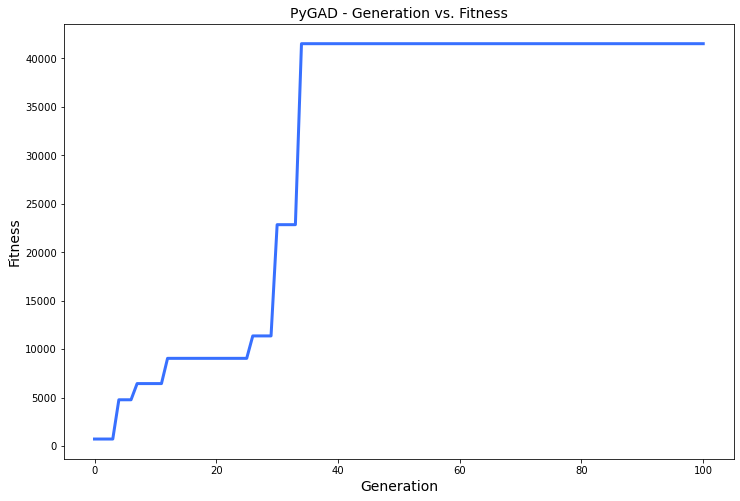

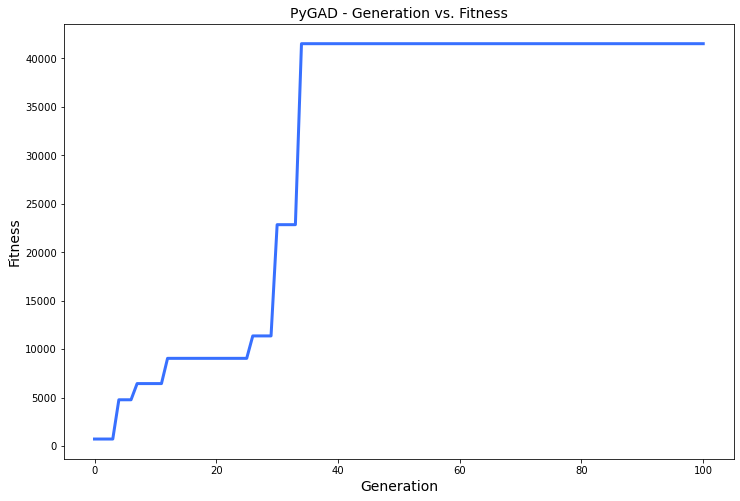

In [24]:
ga_instance2.plot_result()

In [13]:
# Returning the details of the best solution.
solution, solution_fitness, solution_idx = ga_instance2.best_solution()
print("Parameters of the best solution : {solution}".format(solution=solution))
print("Fitness value of the best solution = {solution_fitness}".format(solution_fitness=solution_fitness)) 
print("Index of the best solution : {solution_idx}".format(solution_idx=solution_idx))

=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.911 |===========| 24.763 |==================| 19.294 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.836 |===========| 24.824 |==================| 108.354 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.874 |===========| 24.822 |==================| 140.301 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.423 |===========| 24.79 |==================| 41.721 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.09 |===========| 24.865 |==================| 19.627 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 1.744 |===========| 24.772 |==================| 23.661 |==========
=====|SOLUTION|===========|OUTPUT|==================|FITNESS|==========
======| 0.288 |===========| 24.854 |==========

In [14]:
# Check the model's prediction
prediction2 = numpy.sum(numpy.array(water_model2.function_inputs)*solution)
print("Predicted output based on the best solution :{prediction}".format(prediction=prediction2))

if ga_instance2.best_solution_generation != -1:
    print("Best fitness value reached after {best_solution_generation} generations.".format(best_solution_generation=ga_instance2.best_solution_generation))

Predicted output based on the best solution :0.500204533048902
Best fitness value reached after 34 generations.


In [15]:
# Check solution for confirmation
wn = wntr.network.WaterNetworkModel(water_model2.inp_file_path)
results = water_model2.change_discharge_coefficient(wn, emitter_value=abs(solution[0]))

pressure = results.node['pressure']
presssure_at_N2 = pressure.loc[:,water_model2.node]
print(presssure_at_N2)

0    24.870317
Name: N2, dtype: float64


In [16]:
# Merge all our solutions per generation
solution_per_generation = glob.glob(f"{water_model2.temp_dir}/GENERATION_*")
water_model2.export_results(solutions = solution_per_generation,path=None, name='optimization-result-per-generation_'+water_model2.node.lower())

result_generation = pd.read_csv(water_model2.merged_results+'/optimization-result-per-generation_'+water_model2.node.lower()+'.csv')
result_generation

File Exported Successfully to path: ../leak_size_results/add_leak_node2/merged_results-new/results_for_/optimization-result-per-generation_n2.csv


,GENERATION,FITNESS
0,13.0,9058.575339
1,12.0,9058.575339
2,38.0,41506.090189
3,10.0,6456.083508
4,9.0,6456.083508
...,...,...
95,37.0,41506.090189
96,6.0,4786.242706
97,7.0,6456.083508
98,36.0,41506.090189


In [17]:
fitness_solution_per_population = glob.glob(f"{water_model2.temp_dir}/FITNESS_SOLUTION_*")

water_model2.export_results(solutions = fitness_solution_per_population, path=None, name='optimization-result-per-fitness')
fitness_solution_per_population = pd.read_csv(water_model2.merged_results+'/optimization-result-per-fitness.csv')
fitness_solution_per_population

File Exported Successfully to path: ../leak_size_results/add_leak_node2/merged_results-new/results_for_/optimization-result-per-fitness.csv


,EMITTER_COEFFICIENT_SOLUTION,PRESSURE_OUTPUT,OUTPUT_DEMAND,FITNESS
0,0.289121,24.838138,12.6,42.158058
1,0.832833,24.776618,12.6,26.453872
2,0.867911,24.772608,12.6,23.916966
3,0.867023,24.772710,12.6,23.975174
4,0.008855,24.869380,12.6,18.194049
...,...,...,...,...
2825,0.660587,24.796235,12.6,54.993701
2826,0.650540,24.797376,12.6,58.674056
2827,0.090881,24.860270,12.6,21.809017
2828,0.101858,24.859049,12.6,22.405835


In [18]:
final_data = pd.merge(fitness_solution_per_population,result_generation, how='left',left_on='FITNESS',right_on='FITNESS')
final_data = final_data.sort_values(by='FITNESS',ascending=True)
final_data

,EMITTER_COEFFICIENT_SOLUTION,PRESSURE_OUTPUT,OUTPUT_DEMAND,FITNESS,GENERATION
586,0.999271,24.757549,12.6,17.584010,NaN
2775,0.998650,24.757621,12.6,17.606113,NaN
2773,0.998625,24.757624,12.6,17.606983,NaN
2058,0.998619,24.757624,12.6,17.607197,NaN
1123,0.998056,24.757689,12.6,17.627286,NaN
...,...,...,...,...,...
2020,0.500205,24.814395,12.6,41506.090189,44.0
2019,0.500205,24.814395,12.6,41506.090189,50.0
2018,0.500205,24.814395,12.6,41506.090189,87.0
2046,0.500205,24.814395,12.6,41506.090189,69.0


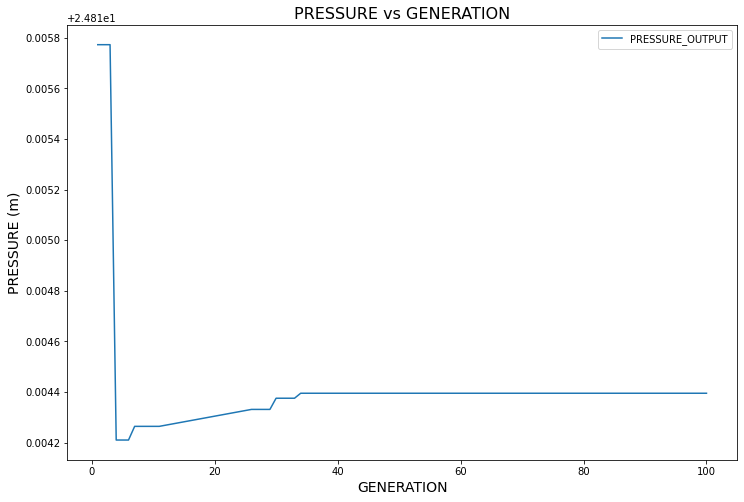

In [19]:
final_data.groupby(['GENERATION'])['PRESSURE_OUTPUT'].min().to_frame().plot()
plt.xlabel('GENERATION',fontsize=14)
plt.ylabel('PRESSURE (m)',fontsize=14)
plt.title('PRESSURE vs GENERATION',fontsize=16)
plt.savefig(water_model2.plots_dir+"/PRESSURE_VS_GENERATION.png")
plt.show();
plt.close()

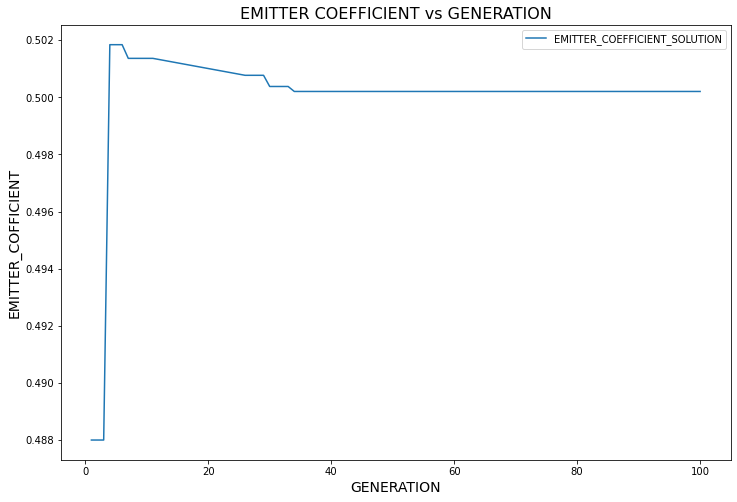

In [26]:
final_data.groupby(['GENERATION'])['EMITTER_COEFFICIENT_SOLUTION'].max().to_frame().plot()
plt.xlabel('GENERATION',fontsize=14)
plt.ylabel('EMITTER_COFFICIENT',fontsize=14)
plt.title('EMITTER COEFFICIENT vs GENERATION',fontsize=16)
plt.show();
plt.savefig(f"{water_model2.plots_dir}/EMITTER_COEFFICIENT.png");
plt.close()

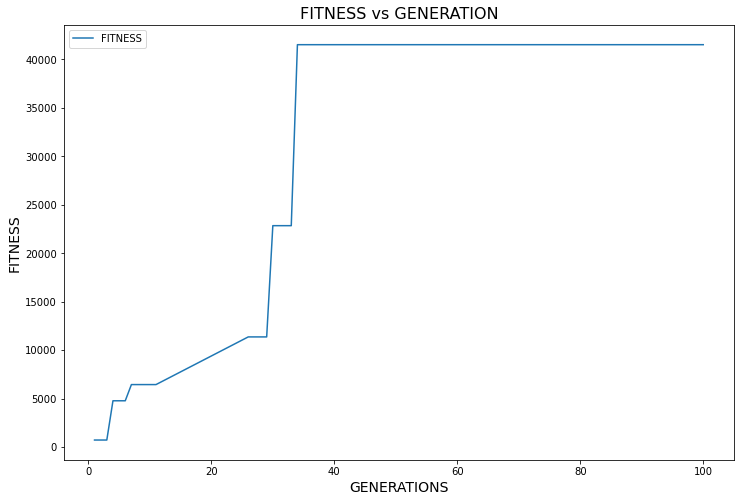

In [21]:
final_data.groupby(['GENERATION'])['FITNESS'].max().to_frame().plot()
plt.xlabel('GENERATIONS',fontsize=14) ### population
plt.ylabel('FITNESS',fontsize=14)
plt.title('FITNESS vs GENERATION',fontsize=16)
plt.show();
plt.savefig(f"{water_model2.plots_dir}/FITNESS_GEN.png")
plt.close()

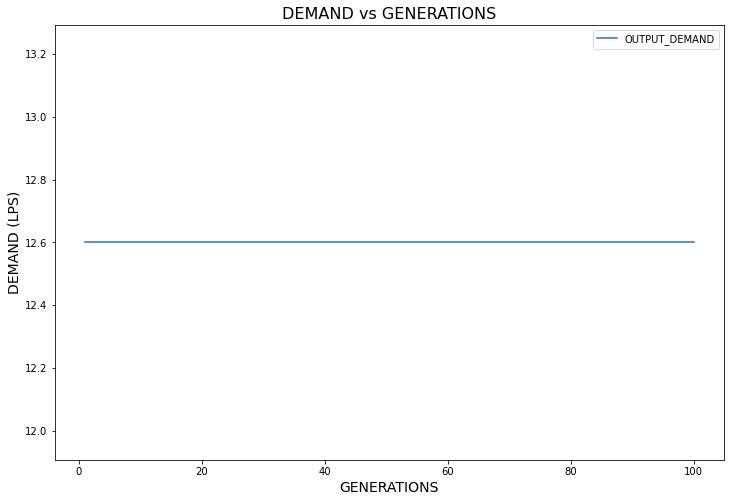

In [22]:
final_data.groupby(['GENERATION'])['OUTPUT_DEMAND'].max().to_frame().plot()
plt.xlabel('GENERATIONS',fontsize=14) ### population
plt.ylabel('DEMAND (LPS)',fontsize=14)
plt.title('DEMAND vs GENERATIONS',fontsize=16)
plt.show();
plt.savefig(f"{water_model2.plots_dir}/DEMAND_VS_GEN.png")
plt.close()

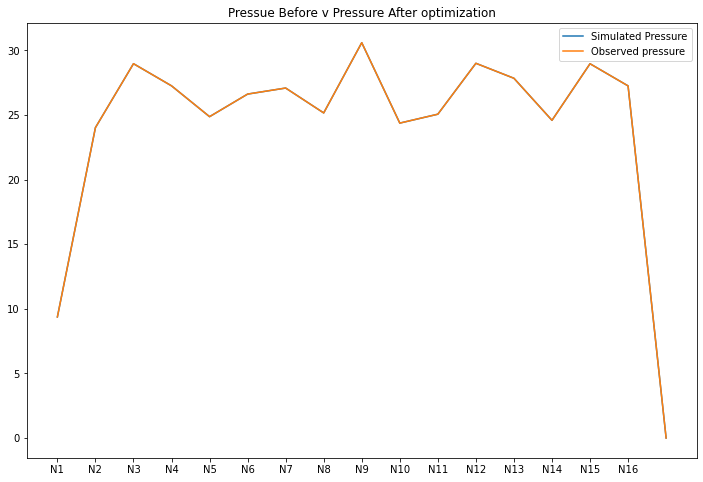

In [27]:
# Plot results on the network:
pressure_before_simulation = pressure_at_0hr.node['pressure'].iloc[:]

# Plot solution vs measurements
plt.plot(pressure_before_simulation.squeeze().values);
plt.plot(pressure.squeeze().values)
plt.legend(['Simulated Pressure','Observed pressure']);
plt.xticks(np.arange(16), ['N1','N2','N3','N4','N5','N6','N7','N8','N9','N10','N11','N12','N13','N14','N15','N16']);
plt.title('Pressue Before v Pressure After optimization');
plt.savefig(f"{water_model2.plots_dir}/pressure_before_and_after_optimization.png")